# Trust as a Mediator: Data Cleaning

## Table of Contents
1. Setup and Load Data
2. Handle Missing Values
3. Create Key Variables
   3.1 Political Tolerance Index
   3.2 Social Trust Variable
   3.3 Urbanicity Categories
   3.4 Control Variables
4. Data Validation
5. Final Dataset Preparation
6. Export Clean Data
7. Cleaning Summary

## 1. Setup and Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src')

pd.set_option('display.max_columns', None)
np.random.seed(42)

print("Setup complete!")

Setup complete!


In [3]:
data_path = "raw_data_gss/gss_raw_data_poltol.csv"
df_raw = pd.read_csv(data_path, low_memory=False)

print(f"Raw data loaded: {df_raw.shape}")
print(f"Date: {pd.Timestamp.now().strftime('%Y-%m-%d')}") 

Raw data loaded: (22656, 38)
Date: 2025-12-19


## 2. Handle Missing Values 


**GSS Missing Value Codes:**
- `.d` = Don't know
- `.i` = Inappropriate (question not asked)
- `.n` = No answer
- `.s` = Skipped
- `98` = Don't know
- `99` = No answer
- `0` = Not applicable (for some variables)

Strategy: Convert all to NaN for consistency

In [3]:
print("="*80)
print("HANDLING MISSING VALUES")
print("="*80)

# Show dataset info before cleaning
print("\nChecking data types and sample values:")
print(df_raw.dtypes.head(20))
print("\nSample of first few rows:")
print(df_raw.head())

# ====== GSS Missing Codes From Documentation ======
missing_numeric_codes = [
    -100, -99, -98, -97, -95, -94, -90, -80, -70, -50, -40
]

missing_string_prefixes = [
    '.i', '.n', '.d', '.s', '.u', '.q', '.r', '.x', '.y', '.p', '.m'
]

# Count missing before cleaning
missing_before = df_raw.isna().sum().sum()
print(f"\nMissing values (NaN) before cleaning: {missing_before:,}")

# Copy raw dataset
df_clean = df_raw.copy()

# Replace numeric missing codes
df_clean.replace(missing_numeric_codes, np.nan, inplace=True)

# Identify object columns
string_cols = df_clean.select_dtypes(include='object').columns

# Convert to string and strip whitespace
df_clean[string_cols] = df_clean[string_cols].apply(
    lambda col: col.astype(str).str.strip()
)

# Extract prefixes (first 2 chars only)
prefixes = df_clean[string_cols].apply(lambda col: col.str[:2])

# Create mask where prefixes match missing codes
mask = prefixes.isin(missing_string_prefixes)

# Convert these values to NaN
df_clean[mask] = np.nan

# Count missing after cleaning
missing_after = df_clean.isna().sum().sum()
print(f"Missing values (NaN) after cleaning: {missing_after:,}")
print(f"Newly identified missing: {missing_after - missing_before:,}")

# ========= Missingness Summary for Key Variables ==========
key_vars = ['trust', 'spkath', 'libath', 'colath', 'xnorcsiz',
            'age', 'educ', 'sex', 'race', 'polviews']

print("\n" + "="*80)
print("MISSING DATA FOR KEY VARIABLES")
print("="*80)
print(f"{'Variable':<15} {'Missing Count':<15} {'Missing %':<15}")
print("-" * 45)

for var in key_vars:
    if var in df_clean.columns:
        missing_count = df_clean[var].isna().sum()
        missing_pct = (missing_count / len(df_clean)) * 100
        print(f"{var:<15} {missing_count:<15,} {missing_pct:<15.1f}%")

# Save cleaned dataset to working variable df
df = df_clean.copy()

print("\nMissing values standardized to NaN successfully.")
print("="*80)


HANDLING MISSING VALUES

Checking data types and sample values:
year         int64
id_          int64
age         object
educ        object
degree      object
sex         object
race        object
income      object
rincome     object
region      object
xnorcsiz    object
srcbelt     object
partyid     object
polviews    object
spkath      object
colath      object
libath      object
spkrac      object
colrac      object
librac      object
dtype: object

Sample of first few rows:
   year  id_ age                 educ                 degree     sex   race  \
0  2010    1  31   4 years of college             Bachelor's    MALE  Other   
1  2010    2  23   4 years of college             Bachelor's  FEMALE  White   
2  2010    3  71            8th grade  Less than high school  FEMALE  Black   
3  2010    4  82           10th grade  Less than high school  FEMALE  White   
4  2010    5  78  No formal schooling  Less than high school  FEMALE  Black   

                           income       

## 3. Create Key Variables 

### 3.1 Political Tolerance Index

In [1]:
print("="*80)
print("FIXING POLITICAL TOLERANCE INDEX USING ORIGINAL DATA")
print("="*80)

# Make a safe working copy from your original data BEFORE cleaning
df_tol = df_raw.copy()

# List of tolerance variables from GSS
tolerance_vars = [
    # Atheist
    'spkath', 'colath', 'libath',
    # Racist
    'spkrac', 'colrac', 'librac',
    # Communist
    'spkcom', 'colcom', 'libcom',
    # Militarist
    'spkmil', 'colmil', 'libmil',
    # Homosexual
    'spkhomo', 'colhomo', 'libhomo',
    # Muslim
    'spkmslm', 'colmslm', 'libmslm'
]

# Keep only those variables which are actually present
available_tolerance = [v for v in tolerance_vars if v in df_tol.columns]

print("\nVariables used for tolerance score:")
print(available_tolerance)

# Standardize text: remove spaces, uppercase
df_tol[available_tolerance] = (
    df_tol[available_tolerance]
    .apply(lambda col: col.astype(str).str.upper().str.strip())
)


### ---------------------- RECODING FUNCTION ---------------------- ###
def recode_tolerance(value):
    if value is None:
        return np.nan
    
    v = str(value)

    # Allowed rights (tolerant)
    if "ALLOWED" in v: 
        return 1
    
    # Prevent double-counting: "NOT ALLOWED" should override above
    if "NOT ALLOWED" in v:
        return 0

    # Book removal
    if "NOT REMOVE" in v:
        return 1
    if "REMOVE" in v:
        return 0
    
    # Hiring
    if "NOT FIRED" in v:
        return 1
    if "FIRED" in v:
        return 0

    return np.nan
### ---------------------------------------------------------------- ###


# Create new DataFrame with recoded values
tolerance_recoded = pd.DataFrame(index=df_tol.index)

for var in available_tolerance:
    tolerance_recoded[var] = df_tol[var].apply(recode_tolerance)

# Count answered questions
df_tol['tolerance_items_answered'] = tolerance_recoded.notna().sum(axis=1)

# Create summary index score
df_tol['tolerance_index'] = tolerance_recoded.sum(axis=1)


print("\nSUMMARY OF TOLERANCE INDEX")
print(df_tol['tolerance_index'].describe())
print("\nCounts of items answered:")
print(df_tol['tolerance_items_answered'].value_counts().sort_index())

print("\n✓ DONE — Political Tolerance Index created correctly")


FIXING POLITICAL TOLERANCE INDEX USING ORIGINAL DATA


NameError: name 'df_raw' is not defined

In [ ]:
df['tolerance_index'] = df_tol['tolerance_index']
df['tolerance_items_answered'] = df_tol['tolerance_items_answered']

In [ ]:
df[['tolerance_index', 'tolerance_items_answered']].head()

## 3.2 Social Trust Variable

In [7]:
print("="*80)
print("CREATING TRUST VARIABLES")
print("="*80)

# Trust variable mappings
trust_mapping = {
    'Can trust': 1,
    'Cannot trust': 2,
    'Depends': 3,
    'Can Trust': 1,
    'Cannot Trust': 2
}

helpful_mapping = {
    'Try to be helpful': 1,
    'Just look out for themselves': 2,
    'Depends': 3,
    'Helpful': 1,
    'Look out for themselves': 2
}

fair_mapping = {
    'Would take advantage': 1,
    'Try to be fair': 2,
    'Depends': 3,
    'Take advantage': 1,
    'Fair': 2
}

# -------------------------------
# PROCESS TRUST
# -------------------------------
print("\n1. Processing TRUST variable:")
print(f"   Original type: {df['trust'].dtype}")
print(f"   Sample values: {df['trust'].dropna().head(3).tolist()}")

# Map or convert to numeric
if df['trust'].dtype == 'object':
    df['trust_numeric'] = df['trust'].map(trust_mapping)
else:
    df['trust_numeric'] = pd.to_numeric(df['trust'], errors='coerce')
    df['trust_numeric'] = df['trust_numeric'].apply(
        lambda x: x if x in [1, 2, 3] else np.nan
    )

print(f"   After mapping: {df['trust_numeric'].notna().sum():,} valid values")
print("   Distribution:")
print(df['trust_numeric'].value_counts().sort_index())

# Create binary trust variable
df['trust_binary'] = df['trust_numeric'].map({1: 1, 2: 0})

df['trust_categorical'] = df['trust_numeric'].copy()

print("\n   Trust Binary:")
print(df['trust_binary'].value_counts(dropna=False))
print(f"   Missing (including 'Depends'): {df['trust_binary'].isna().sum():,}")


# -------------------------------
# PROCESS HELPFUL
# -------------------------------
if 'helpful' in df.columns:
    print("\n2. Processing HELPFUL variable:")
    if df['helpful'].dtype == 'object':
        df['helpful_numeric'] = df['helpful'].map(helpful_mapping)
    else:
        df['helpful_numeric'] = pd.to_numeric(df['helpful'], errors='coerce')
        df['helpful_numeric'] = df['helpful_numeric'].apply(
            lambda x: x if x in [1, 2, 3] else np.nan
        )
    print(f"   Valid values: {df['helpful_numeric'].notna().sum():,}")


# -------------------------------
# PROCESS FAIR
# -------------------------------
if 'fair' in df.columns:
    print("\n3. Processing FAIR variable:")
    if df['fair'].dtype == 'object':
        df['fair_numeric'] = df['fair'].map(fair_mapping)
    else:
        df['fair_numeric'] = pd.to_numeric(df['fair'], errors='coerce')
        df['fair_numeric'] = df['fair_numeric'].apply(
            lambda x: x if x in [1, 2, 3] else np.nan
        )
    print(f"   Valid values: {df['fair_numeric'].notna().sum():,}")


# -------------------------------
# VISUALIZE TRUST
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Binary trust
trust_counts = df['trust_binary'].value_counts().sort_index()

if len(trust_counts) > 0:
    bars = axes[0].bar(
        ["Can't Trust\n(0)", "Can Trust\n(1)"],
        [trust_counts.get(0, 0), trust_counts.get(1, 0)],
        color=['#e74c3c', '#2ecc71'],
        alpha=0.8, 
        edgecolor='black', linewidth=1.5
    )

    axes[0].set_title('Social Trust (Binary)\n"Can people be trusted?"',
                      fontsize=14, fontweight='bold', pad=15)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].grid(axis='y', alpha=0.3)

    # Add labels# ============================================================================
# GSS DATA CLEANING - STEP-BY-STEP GUIDE
# ============================================================================

# %% SETUP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Libraries loaded")

# %% STEP 0: LOAD RAW DATA
df_raw = pd.read_excel('gss_raw_data_poltolfinal.xlsx')
print(f"✓ Data loaded: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"✓ Years: {sorted(df_raw['year'].unique())}")

# Create working copy
df = df_raw.copy()

# %% ============================================================================
# STEP 1: POLITICAL TOLERANCE INDEX (YOUR EXISTING CODE)
# ============================================================================
print("\n" + "="*80)
print("STEP 1: POLITICAL TOLERANCE INDEX")
print("="*80)

tolerance_vars = [
    'spkath', 'colath', 'libath',
    'spkrac', 'colrac', 'librac',
    'spkcom', 'colcom', 'libcom',
    'spkmil', 'colmil', 'libmil',
    'spkhomo', 'colhomo', 'libhomo',
    'spkmslm', 'colmslm', 'libmslm'
]

available_tolerance = [v for v in tolerance_vars if v in df.columns]
print(f"\n✓ Using {len(available_tolerance)} tolerance variables")

# Standardize text
df[available_tolerance] = (
    df[available_tolerance]
    .apply(lambda col: col.astype(str).str.upper().str.strip())
)

def recode_tolerance(value):
    if value is None:
        return np.nan
    v = str(value)
    if "ALLOWED" in v: 
        return 1
    if "NOT ALLOWED" in v:
        return 0
    if "NOT REMOVE" in v:
        return 1
    if "REMOVE" in v:
        return 0
    if "NOT FIRED" in v:
        return 1
    if "FIRED" in v:
        return 0
    return np.nan

tolerance_recoded = pd.DataFrame(index=df.index)
for var in available_tolerance:
    tolerance_recoded[var] = df[var].apply(recode_tolerance)

df['tolerance_items_answered'] = tolerance_recoded.notna().sum(axis=1)
df['tolerance_index'] = tolerance_recoded.sum(axis=1)

# Calculate PROPORTION (0-1 scale) instead of sum
df['tolerance_proportion'] = df['tolerance_index'] / df['tolerance_items_answered']

print("\n✓ Political Tolerance Summary:")
print(df[['tolerance_index', 'tolerance_items_answered', 'tolerance_proportion']].describe())

# %% ============================================================================
# STEP 2: SOCIAL TRUST SCALE (CORRECTED VERSION)
# ============================================================================
print("\n" + "="*80)
print("STEP 2: SOCIAL TRUST SCALE (CORRECTED)")
print("="*80)

# ISSUES IN YOUR CODE:
# 1. The 'fair' mapping was BACKWARDS (1=take advantage, 2=fair is WRONG)
# 2. You weren't standardizing text like you did for tolerance
# 3. You weren't creating a composite scale (just trust_binary)
# 4. Missing the scale averaging approach

print("\nFirst, let's examine the RAW values:")
for var in ['trust', 'fair', 'helpful']:
    if var in df.columns:
        print(f"\n{var.upper()} - Raw unique values:")
        print(df[var].value_counts(dropna=False).head(10))

# Standardize text (same approach as tolerance)
trust_vars = ['trust', 'fair', 'helpful']
available_trust = [v for v in trust_vars if v in df.columns]

print(f"\n✓ Found {len(available_trust)} trust variables: {available_trust}")

# Standardize text formatting
df[available_trust] = (
    df[available_trust]
    .apply(lambda col: col.astype(str).str.upper().str.strip())
)

# %% RECODE EACH TRUST VARIABLE

# -------------------------------
# 1. TRUST: "Can people be trusted?"
# -------------------------------
print("\n" + "-"*70)
print("Processing TRUST variable")
print("-"*70)

def recode_trust(value):
    """
    GSS Trust: Can people be trusted?
    - 1 = Can trust (TRUSTING)
    - 2 = Cannot trust (NOT TRUSTING)
    - 3 = Depends (treat as missing)
    """
    if value is None or pd.isna(value):
        return np.nan
    
    v = str(value).upper()
    
    # Trusting responses
    if any(x in v for x in ['CAN TRUST', 'CAN BE TRUSTED', 'TRUST']):
        if 'CANNOT' not in v and 'CAN\'T' not in v and 'NOT' not in v:
            return 1
    
    # Not trusting responses
    if any(x in v for x in ['CANNOT', 'CAN\'T', 'NOT TRUST']):
        return 0
    
    # Depends = missing
    if 'DEPEND' in v:
        return np.nan
    
    # If numeric, handle directly
    if v.replace('.', '').isdigit():
        num = float(v)
        if num == 1:
            return 1
        elif num == 2:
            return 0
        elif num == 3:
            return np.nan
    
    return np.nan

if 'trust' in df.columns:
    df['trust_clean'] = df['trust'].apply(recode_trust)
    print(f"Original values: {df['trust'].value_counts(dropna=False).to_dict()}")
    print(f"\nRecoded distribution:")
    print(f"  Trusting (1): {(df['trust_clean']==1).sum():,}")
    print(f"  Not trusting (0): {(df['trust_clean']==0).sum():,}")
    print(f"  Missing/Depends: {df['trust_clean'].isna().sum():,}")

# -------------------------------
# 2. FAIR: "Are people fair or take advantage?"
# -------------------------------
print("\n" + "-"*70)
print("Processing FAIR variable")
print("-"*70)

def recode_fair(value):
    """
    GSS Fair: Try to be fair or take advantage?
    CORRECTED CODING:
    - 1 = Try to be fair (TRUSTING)
    - 2 = Take advantage (NOT TRUSTING)
    - 3 = Depends (treat as missing)
    """
    if value is None or pd.isna(value):
        return np.nan
    
    v = str(value).upper()
    
    # Trusting responses (fair)
    if any(x in v for x in ['FAIR', 'BE FAIR']):
        if 'NOT' not in v:
            return 1
    
    # Not trusting responses (take advantage)
    if any(x in v for x in ['ADVANTAGE', 'TAKE ADVANTAGE', 'LOOK OUT']):
        return 0
    
    # Depends = missing
    if 'DEPEND' in v:
        return np.nan
    
    # If numeric
    if v.replace('.', '').isdigit():
        num = float(v)
        if num == 1:
            return 1  # Fair = trusting
        elif num == 2:
            return 0  # Take advantage = not trusting
        elif num == 3:
            return np.nan
    
    return np.nan

if 'fair' in df.columns:
    df['fair_clean'] = df['fair'].apply(recode_fair)
    print(f"Original values: {df['fair'].value_counts(dropna=False).to_dict()}")
    print(f"\nRecoded distribution:")
    print(f"  Fair/Trusting (1): {(df['fair_clean']==1).sum():,}")
    print(f"  Take advantage/Not trusting (0): {(df['fair_clean']==0).sum():,}")
    print(f"  Missing/Depends: {df['fair_clean'].isna().sum():,}")

# -------------------------------
# 3. HELPFUL: "Are people helpful or look out for themselves?"
# -------------------------------
print("\n" + "-"*70)
print("Processing HELPFUL variable")
print("-"*70)

def recode_helpful(value):
    """
    GSS Helpful: Try to be helpful or look out for selves?
    - 1 = Try to be helpful (TRUSTING)
    - 2 = Look out for themselves (NOT TRUSTING)
    - 3 = Depends (treat as missing)
    """
    if value is None or pd.isna(value):
        return np.nan
    
    v = str(value).upper()
    
    # Trusting responses (helpful)
    if any(x in v for x in ['HELPFUL', 'BE HELPFUL', 'HELP']):
        if 'NOT' not in v:
            return 1
    
    # Not trusting responses (look out for self)
    if any(x in v for x in ['LOOK OUT', 'THEMSELVES', 'LOOK AFTER']):
        return 0
    
    # Depends = missing
    if 'DEPEND' in v:
        return np.nan
    
    # If numeric
    if v.replace('.', '').isdigit():
        num = float(v)
        if num == 1:
            return 1
        elif num == 2:
            return 0
        elif num == 3:
            return np.nan
    
    return np.nan

if 'helpful' in df.columns:
    df['helpful_clean'] = df['helpful'].apply(recode_helpful)
    print(f"Original values: {df['helpful'].value_counts(dropna=False).to_dict()}")
    print(f"\nRecoded distribution:")
    print(f"  Helpful/Trusting (1): {(df['helpful_clean']==1).sum():,}")
    print(f"  Look out for self/Not trusting (0): {(df['helpful_clean']==0).sum():,}")
    print(f"  Missing/Depends: {df['helpful_clean'].isna().sum():,}")

# %% CREATE SOCIAL TRUST SCALE (COMPOSITE)

print("\n" + "="*80)
print("CREATING SOCIAL TRUST COMPOSITE SCALE")
print("="*80)

# List of cleaned trust items
trust_items_clean = [v + '_clean' for v in available_trust]

# Count how many items each person answered
df['trust_items_answered'] = df[trust_items_clean].notna().sum(axis=1)

# Create scale as AVERAGE of items (0-1 scale)
df['social_trust'] = df[trust_items_clean].mean(axis=1)

# Optional: Require minimum 2 of 3 items
# df.loc[df['trust_items_answered'] < 2, 'social_trust'] = np.nan

print(f"\nSocial Trust Scale Summary:")
print(df['social_trust'].describe())
print(f"\nItems answered per person:")
print(df['trust_items_answered'].value_counts().sort_index())

# Calculate Cronbach's Alpha
def cronbach_alpha(items_df):
    """Calculate Cronbach's alpha reliability"""
    items_df = items_df.dropna()
    if len(items_df) < 2 or items_df.shape[1] < 2:
        return np.nan
    k = items_df.shape[1]
    item_vars = items_df.var(axis=0)
    total_var = items_df.sum(axis=1).var()
    if total_var == 0:
        return np.nan
    return (k / (k-1)) * (1 - item_vars.sum() / total_var)

alpha = cronbach_alpha(df[trust_items_clean])
print(f"\n✓ Cronbach's α = {alpha:.3f}")

# Check inter-item correlations
print(f"\nInter-item correlations:")
print(df[trust_items_clean].corr().round(3))

# %% VISUALIZE SOCIAL TRUST

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Social Trust Variables', fontsize=16, fontweight='bold')

# 1. Trust distribution
ax = axes[0, 0]
if 'trust_clean' in df.columns:
    trust_counts = df['trust_clean'].value_counts().sort_index()
    colors = ['#e74c3c', '#2ecc71']
    ax.bar([0, 1], [trust_counts.get(0, 0), trust_counts.get(1, 0)], 
           color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Cannot Trust\n(0)', 'Can Trust\n(1)'])
    ax.set_title('TRUST: Can people be trusted?', fontweight='bold', pad=10)
    ax.set_ylabel('Count')
    ax.grid(axis='y', alpha=0.3)
    
    # Add percentages
    total = trust_counts.sum()
    for i, val in enumerate([trust_counts.get(0, 0), trust_counts.get(1, 0)]):
        pct = (val / total * 100) if total > 0 else 0
        ax.text(i, val, f'{val:,}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

# 2. Fair distribution
ax = axes[0, 1]
if 'fair_clean' in df.columns:
    fair_counts = df['fair_clean'].value_counts().sort_index()
    ax.bar([0, 1], [fair_counts.get(0, 0), fair_counts.get(1, 0)], 
           color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Take Advantage\n(0)', 'Fair\n(1)'])
    ax.set_title('FAIR: Try to be fair?', fontweight='bold', pad=10)
    ax.set_ylabel('Count')
    ax.grid(axis='y', alpha=0.3)
    
    total = fair_counts.sum()
    for i, val in enumerate([fair_counts.get(0, 0), fair_counts.get(1, 0)]):
        pct = (val / total * 100) if total > 0 else 0
        ax.text(i, val, f'{val:,}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

# 3. Helpful distribution
ax = axes[1, 0]
if 'helpful_clean' in df.columns:
    helpful_counts = df['helpful_clean'].value_counts().sort_index()
    ax.bar([0, 1], [helpful_counts.get(0, 0), helpful_counts.get(1, 0)], 
           color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Look Out for Self\n(0)', 'Helpful\n(1)'])
    ax.set_title('HELPFUL: Try to be helpful?', fontweight='bold', pad=10)
    ax.set_ylabel('Count')
    ax.grid(axis='y', alpha=0.3)
    
    total = helpful_counts.sum()
    for i, val in enumerate([helpful_counts.get(0, 0), helpful_counts.get(1, 0)]):
        pct = (val / total * 100) if total > 0 else 0
        ax.text(i, val, f'{val:,}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

# 4. Social Trust composite distribution
ax = axes[1, 1]
df['social_trust'].hist(bins=30, ax=ax, color='#3498db', alpha=0.8, edgecolor='black')
ax.axvline(df['social_trust'].mean(), color='red', linestyle='--', linewidth=2,
           label=f"Mean = {df['social_trust'].mean():.3f}")
ax.axvline(df['social_trust'].median(), color='green', linestyle='--', linewidth=2,
           label=f"Median = {df['social_trust'].median():.3f}")
ax.set_title('SOCIAL TRUST Composite Scale', fontweight='bold', pad=10)
ax.set_xlabel('Social Trust (0=Low, 1=High)')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Social Trust variables created successfully!")
print("="*80)

# %% SUMMARY COMPARISON
print("\nCOMPARISON: Tolerance vs Trust")
print("="*80)
print(f"\nPolitical Tolerance:")
print(f"  Mean: {df['tolerance_proportion'].mean():.3f}")
print(f"  SD: {df['tolerance_proportion'].std():.3f}")
print(f"  Valid N: {df['tolerance_proportion'].notna().sum():,}")

print(f"\nSocial Trust:")
print(f"  Mean: {df['social_trust'].mean():.3f}")
print(f"  SD: {df['social_trust'].std():.3f}")
print(f"  Valid N: {df['social_trust'].notna().sum():,}")

print(f"\nCorrelation between Tolerance and Trust:")
corr = df[['tolerance_proportion', 'social_trust']].corr().iloc[0, 1]
print(f"  r = {corr:.3f}")

# %% NEXT STEPS
print("\n" + "="*80)
print("NEXT: Run the urbanicity and control variables cleaning!")
print("="*80)
    total = trust_counts.sum()
    for bar in bars:
        height = bar.get_height()
        pct = (height / total * 100) if total > 0 else 0
        axes[0].text(
            bar.get_x() + bar.get_width() / 2,
            height + max(total * 0.01, 10),
            f"{height:,}\n({pct:.1f}%)",
            ha='center', va='bottom', fontsize=10
        )

else:
    axes[0].text(0.5, 0.5, "No trust data available",
                 ha='center', va='center', fontsize=12)


plt.tight_layout()
plt.show()


IndentationError: unexpected indent (1761042841.py, line 525)

## 3.3 Urbanicity Categories

In [ ]:
# %% ============================================================================
# STEP 2: SOCIAL TRUST SCALE (CORRECTED VERSION)
# ============================================================================
print("\n" + "="*80)
print("STEP 2: SOCIAL TRUST SCALE (CORRECTED)")
print("="*80)

# ISSUES IN YOUR CODE:
# 1. The 'fair' mapping was BACKWARDS (1=take advantage, 2=fair is WRONG)
# 2. You weren't standardizing text like you did for tolerance
# 3. You weren't creating a composite scale (just trust_binary)
# 4. Missing the scale averaging approach

print("\nFirst, let's examine the RAW values:")
for var in ['trust', 'fair', 'helpful']:
    if var in df.columns:
        print(f"\n{var.upper()} - Raw unique values:")
        print(df[var].value_counts(dropna=False).head(10))

# Standardize text (same approach as tolerance)
trust_vars = ['trust', 'fair', 'helpful']
available_trust = [v for v in trust_vars if v in df.columns]

print(f"\n✓ Found {len(available_trust)} trust variables: {available_trust}")

# Standardize text formatting
df[available_trust] = (
    df[available_trust]
    .apply(lambda col: col.astype(str).str.upper().str.strip())
)

# %% RECODE EACH TRUST VARIABLE

# -------------------------------
# 1. TRUST: "Can people be trusted?"
# -------------------------------
print("\n" + "-"*70)
print("Processing TRUST variable")
print("-"*70)

def recode_trust(value):
    """
    GSS Trust: Can people be trusted?
    - 1 = Can trust (TRUSTING)
    - 2 = Cannot trust (NOT TRUSTING)
    - 3 = Depends (treat as missing)
    """
    if value is None or pd.isna(value):
        return np.nan
    
    v = str(value).upper()
    
    # Trusting responses
    if any(x in v for x in ['CAN TRUST', 'CAN BE TRUSTED', 'TRUST']):
        if 'CANNOT' not in v and 'CAN\'T' not in v and 'NOT' not in v:
            return 1
    
    # Not trusting responses
    if any(x in v for x in ['CANNOT', 'CAN\'T', 'NOT TRUST']):
        return 0
    
    # Depends = missing
    if 'DEPEND' in v:
        return np.nan
    
    # If numeric, handle directly
    if v.replace('.', '').isdigit():
        num = float(v)
        if num == 1:
            return 1
        elif num == 2:
            return 0
        elif num == 3:
            return np.nan
    
    return np.nan

if 'trust' in df.columns:
    df['trust_clean'] = df['trust'].apply(recode_trust)
    print(f"Original values: {df['trust'].value_counts(dropna=False).to_dict()}")
    print(f"\nRecoded distribution:")
    print(f"  Trusting (1): {(df['trust_clean']==1).sum():,}")
    print(f"  Not trusting (0): {(df['trust_clean']==0).sum():,}")
    print(f"  Missing/Depends: {df['trust_clean'].isna().sum():,}")

# -------------------------------
# 2. FAIR: "Are people fair or take advantage?"
# -------------------------------
print("\n" + "-"*70)
print("Processing FAIR variable")
print("-"*70)

def recode_fair(value):
    """
    GSS Fair: Try to be fair or take advantage?
    CORRECTED CODING:
    - 1 = Try to be fair (TRUSTING)
    - 2 = Take advantage (NOT TRUSTING)
    - 3 = Depends (treat as missing)
    """
    if value is None or pd.isna(value):
        return np.nan
    
    v = str(value).upper()
    
    # Trusting responses (fair)
    if any(x in v for x in ['FAIR', 'BE FAIR']):
        if 'NOT' not in v:
            return 1
    
    # Not trusting responses (take advantage)
    if any(x in v for x in ['ADVANTAGE', 'TAKE ADVANTAGE', 'LOOK OUT']):
        return 0
    
    # Depends = missing
    if 'DEPEND' in v:
        return np.nan
    
    # If numeric
    if v.replace('.', '').isdigit():
        num = float(v)
        if num == 1:
            return 1  # Fair = trusting
        elif num == 2:
            return 0  # Take advantage = not trusting
        elif num == 3:
            return np.nan
    
    return np.nan

if 'fair' in df.columns:
    df['fair_clean'] = df['fair'].apply(recode_fair)
    print(f"Original values: {df['fair'].value_counts(dropna=False).to_dict()}")
    print(f"\nRecoded distribution:")
    print(f"  Fair/Trusting (1): {(df['fair_clean']==1).sum():,}")
    print(f"  Take advantage/Not trusting (0): {(df['fair_clean']==0).sum():,}")
    print(f"  Missing/Depends: {df['fair_clean'].isna().sum():,}")

# -------------------------------
# 3. HELPFUL: "Are people helpful or look out for themselves?"
# -------------------------------
print("\n" + "-"*70)
print("Processing HELPFUL variable")
print("-"*70)

def recode_helpful(value):
    """
    GSS Helpful: Try to be helpful or look out for selves?
    - 1 = Try to be helpful (TRUSTING)
    - 2 = Look out for themselves (NOT TRUSTING)
    - 3 = Depends (treat as missing)
    """
    if value is None or pd.isna(value):
        return np.nan
    
    v = str(value).upper()
    
    # Trusting responses (helpful)
    if any(x in v for x in ['HELPFUL', 'BE HELPFUL', 'HELP']):
        if 'NOT' not in v:
            return 1
    
    # Not trusting responses (look out for self)
    if any(x in v for x in ['LOOK OUT', 'THEMSELVES', 'LOOK AFTER']):
        return 0
    
    # Depends = missing
    if 'DEPEND' in v:
        return np.nan
    
    # If numeric
    if v.replace('.', '').isdigit():
        num = float(v)
        if num == 1:
            return 1
        elif num == 2:
            return 0
        elif num == 3:
            return np.nan
    
    return np.nan

if 'helpful' in df.columns:
    df['helpful_clean'] = df['helpful'].apply(recode_helpful)
    print(f"Original values: {df['helpful'].value_counts(dropna=False).to_dict()}")
    print(f"\nRecoded distribution:")
    print(f"  Helpful/Trusting (1): {(df['helpful_clean']==1).sum():,}")
    print(f"  Look out for self/Not trusting (0): {(df['helpful_clean']==0).sum():,}")
    print(f"  Missing/Depends: {df['helpful_clean'].isna().sum():,}")

# %% CREATE SOCIAL TRUST SCALE (COMPOSITE)

print("\n" + "="*80)
print("CREATING SOCIAL TRUST COMPOSITE SCALE")
print("="*80)

# List of cleaned trust items
trust_items_clean = [v + '_clean' for v in available_trust]

# Count how many items each person answered
df['trust_items_answered'] = df[trust_items_clean].notna().sum(axis=1)

# Create scale as AVERAGE of items (0-1 scale)
df['social_trust'] = df[trust_items_clean].mean(axis=1)

# Optional: Require minimum 2 of 3 items
# df.loc[df['trust_items_answered'] < 2, 'social_trust'] = np.nan

print(f"\nSocial Trust Scale Summary:")
print(df['social_trust'].describe())
print(f"\nItems answered per person:")
print(df['trust_items_answered'].value_counts().sort_index())

# Calculate Cronbach's Alpha
def cronbach_alpha(items_df):
    """Calculate Cronbach's alpha reliability"""
    items_df = items_df.dropna()
    if len(items_df) < 2 or items_df.shape[1] < 2:
        return np.nan
    k = items_df.shape[1]
    item_vars = items_df.var(axis=0)
    total_var = items_df.sum(axis=1).var()
    if total_var == 0:
        return np.nan
    return (k / (k-1)) * (1 - item_vars.sum() / total_var)

alpha = cronbach_alpha(df[trust_items_clean])
print(f"\n✓ Cronbach's α = {alpha:.3f}")

# Check inter-item correlations
print(f"\nInter-item correlations:")
print(df[trust_items_clean].corr().round(3))

# %% VISUALIZE SOCIAL TRUST

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Social Trust Variables', fontsize=16, fontweight='bold')

# 1. Trust distribution
ax = axes[0, 0]
if 'trust_clean' in df.columns:
    trust_counts = df['trust_clean'].value_counts().sort_index()
    colors = ['#e74c3c', '#2ecc71']
    ax.bar([0, 1], [trust_counts.get(0, 0), trust_counts.get(1, 0)], 
           color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Cannot Trust\n(0)', 'Can Trust\n(1)'])
    ax.set_title('TRUST: Can people be trusted?', fontweight='bold', pad=10)
    ax.set_ylabel('Count')
    ax.grid(axis='y', alpha=0.3)
    # Add percentages
    total = trust_counts.sum()
    for i, val in enumerate([trust_counts.get(0, 0), trust_counts.get(1, 0)]):
        pct = (val / total * 100) if total > 0 else 0
        ax.text(i, val, f'{val:,}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

# 2. Fair distribution
ax = axes[0, 1]
if 'fair_clean' in df.columns:
    fair_counts = df['fair_clean'].value_counts().sort_index()
    ax.bar([0, 1], [fair_counts.get(0, 0), fair_counts.get(1, 0)], 
           color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Take Advantage\n(0)', 'Fair\n(1)'])
    ax.set_title('FAIR: Try to be fair?', fontweight='bold', pad=10)
    ax.set_ylabel('Count')
    ax.grid(axis='y', alpha=0.3)
    total = fair_counts.sum()
    for i, val in enumerate([fair_counts.get(0, 0), fair_counts.get(1, 0)]):
        pct = (val / total * 100) if total > 0 else 0
        ax.text(i, val, f'{val:,}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

# 3. Helpful distribution
ax = axes[1, 0]
if 'helpful_clean' in df.columns:
    helpful_counts = df['helpful_clean'].value_counts().sort_index()
    ax.bar([0, 1], [helpful_counts.get(0, 0), helpful_counts.get(1, 0)], 
           color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Look Out for Self\n(0)', 'Helpful\n(1)'])
    ax.set_title('HELPFUL: Try to be helpful?', fontweight='bold', pad=10)
    ax.set_ylabel('Count')
    ax.grid(axis='y', alpha=0.3)
    total = helpful_counts.sum()
    for i, val in enumerate([helpful_counts.get(0, 0), helpful_counts.get(1, 0)]):
        pct = (val / total * 100) if total > 0 else 0
        ax.text(i, val, f'{val:,}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

# 4. Social Trust composite distribution
ax = axes[1, 1]
df['social_trust'].hist(bins=30, ax=ax, color='#3498db', alpha=0.8, edgecolor='black')
ax.axvline(df['social_trust'].mean(), color='red', linestyle='--', linewidth=2,
           label=f"Mean = {df['social_trust'].mean():.3f}")
ax.axvline(df['social_trust'].median(), color='green', linestyle='--', linewidth=2,
           label=f"Median = {df['social_trust'].median():.3f}")
ax.set_title('SOCIAL TRUST Composite Scale', fontweight='bold', pad=10)
ax.set_xlabel('Social Trust (0=Low, 1=High)')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Social Trust variables created successfully!")
print("="*80)

In [ ]:
# %% ============================================================================
# STEP 3: URBANICITY CATEGORIES (CORRECTED)
# ============================================================================
print("\n" + "="*80)
print("STEP 3: URBANICITY CATEGORIES")
print("="*80)

# First, let's see what we have
print("\nExamining XNORCSIZ variable:")
if 'xnorcsiz' in df.columns:
    print(f"Data type: {df['xnorcsiz'].dtype}")
    print(f"\nRaw unique values:")
    print(sorted(df['xnorcsiz'].dropna().unique()))
    print(f"\nValue counts:")
    print(df['xnorcsiz'].value_counts(dropna=False).sort_index())
else:
    print("⚠️ WARNING: xnorcsiz variable not found!")
    print(f"Available columns: {df.columns.tolist()}")

# Standardize if it's text (like your other variables)
if 'xnorcsiz' in df.columns:
    if df['xnorcsiz'].dtype == 'object':
        print("\n✓ Converting text to standardized format...")
        df['xnorcsiz'] = df['xnorcsiz'].astype(str).str.upper().str.strip()
        print("After standardization:")
        print(df['xnorcsiz'].value_counts(dropna=False).sort_index())

# Categorization function (CORRECTED)
def categorize_urbanicity(value):
    """
    Categorize urbanicity based on XNORCSIZ codes
    
    XNORCSIZ Coding:
    1 = 12 largest SMSAs (Urban)
    2 = 13-100 largest SMSAs (Urban)
    3 = Suburb, 12 largest SMSAs (Suburban)
    4 = Suburb, 13-100 largest SMSAs (Suburban)
    5 = Other urban (Suburban)
    6 = Other rural (Rural)
    7 = Open country (Rural)
    
    Alternative interpretation if your data uses different codes:
    1-2 = Urban (central cities)
    3-6 = Suburban (suburbs and smaller urban)
    7-10 = Rural (towns and open country)
    """
    if pd.isna(value):
        return np.nan
    
    # Convert to string for text-based data
    v = str(value).upper().strip()
    
    # Handle numeric codes
    if v.replace('.', '').replace('-', '').isdigit():
        code = float(v)
        
        # Standard XNORCSIZ coding (1-7)
        if code in [1, 2]:
            return 'Urban'
        elif code in [3, 4, 5]:
            return 'Suburban'
        elif code in [6, 7]:
            return 'Rural'
        # Extended coding if present (1-10)
        elif code in [8, 9, 10]:
            return 'Rural'
        else:
            return np.nan
    
    # Handle text descriptions
    if any(x in v for x in ['CITY', 'URBAN', 'SMSA', 'CENTRAL']):
        if 'SUBURB' not in v:
            return 'Urban'
    
    if any(x in v for x in ['SUBURB', 'UNINCORPORATED']):
        return 'Suburban'
    
    if any(x in v for x in ['RURAL', 'COUNTRY', 'TOWN', 'VILLAGE']):
        return 'Rural'
    
    return np.nan

# Create urbanicity categories
if 'xnorcsiz' in df.columns:
    df['urban_category'] = df['xnorcsiz'].apply(categorize_urbanicity)
    
    # Create numeric ordinal version (0=Rural, 1=Suburban, 2=Urban)
    df['urban_numeric'] = df['urban_category'].map({
        'Rural': 0,
        'Suburban': 1,
        'Urban': 2
    })
    
    # Create dummy variables
    df['urban_dummy'] = (df['urban_category'] == 'Urban').astype(float)
    df['suburban_dummy'] = (df['urban_category'] == 'Suburban').astype(float)
    df['rural_dummy'] = (df['urban_category'] == 'Rural').astype(float)
    
    # Set missing to NaN
    for var in ['urban_dummy', 'suburban_dummy', 'rural_dummy', 'urban_numeric']:
        df.loc[df['urban_category'].isna(), var] = np.nan
    
    # Display results
    print("\n" + "-"*70)
    print("URBANICITY CATEGORIZATION RESULTS")
    print("-"*70)
    
    urban_counts = df['urban_category'].value_counts(dropna=False)
    print(f"\nCategory Distribution:")
    for category in ['Urban', 'Suburban', 'Rural']:
        count = urban_counts.get(category, 0)
        pct = (count / len(df) * 100) if len(df) > 0 else 0
        print(f"  {category:12s}: {count:6,} ({pct:5.1f}%)")
    
    missing = df['urban_category'].isna().sum()
    print(f"  {'Missing':12s}: {missing:6,} ({missing/len(df)*100:5.1f}%)")
    print(f"  {'Total':12s}: {len(df):6,}")
    
    # Show how original codes map to categories
    print(f"\nMapping of original XNORCSIZ codes to categories:")
    mapping_df = df.groupby(['xnorcsiz', 'urban_category']).size().reset_index(name='count')
    mapping_df = mapping_df.sort_values('xnorcsiz')
    print(mapping_df.to_string(index=False))
    
    print("\n✓ Urbanicity categories created successfully!")

else:
    print("\n⚠️ Cannot create urbanicity categories - xnorcsiz variable not found")
    print("Available location variables:")
    location_vars = [col for col in df.columns if any(x in col.lower() for x in ['region', 'city', 'urban', 'rural', 'size'])]
    print(location_vars if location_vars else "None found")

# %% VISUALIZE URBANICITY

if 'urban_category' in df.columns and df['urban_category'].notna().sum() > 0:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Urbanicity Distribution and Relationships', fontsize=16, fontweight='bold')
    
    # 1. Category distribution
    ax = axes[0]
    urban_counts = df['urban_category'].value_counts()
    colors_map = {'Urban': '#e74c3c', 'Suburban': '#f39c12', 'Rural': '#27ae60'}
    colors = [colors_map.get(cat, '#95a5a6') for cat in urban_counts.index]
    
    bars = ax.bar(range(len(urban_counts)), urban_counts.values, color=colors, 
                  alpha=0.8, edgecolor='black', linewidth=1.5)
    ax.set_xticks(range(len(urban_counts)))
    ax.set_xticklabels(urban_counts.index, fontweight='bold')
    ax.set_title('Urbanicity Distribution', fontweight='bold', pad=10)
    ax.set_ylabel('Count')
    ax.grid(axis='y', alpha=0.3)
    
    # Add counts and percentages
    total = urban_counts.sum()
    for i, (bar, count) in enumerate(zip(bars, urban_counts.values)):
        pct = (count / total * 100) if total > 0 else 0
        ax.text(bar.get_x() + bar.get_width()/2, count,
                f'{count:,}\n({pct:.1f}%)', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Define positions for all plots
    positions = {'Urban': 0, 'Suburban': 1, 'Rural': 2}
    
    # 2. Tolerance by Urbanicity
    ax = axes[1]
    if 'tolerance_proportion' in df.columns:
        df_plot = df[df['urban_category'].notna() & df['tolerance_proportion'].notna()]
        
        for category in ['Urban', 'Suburban', 'Rural']:
            data = df_plot[df_plot['urban_category'] == category]['tolerance_proportion']
            if len(data) > 0:
                pos = positions[category]
                bp = ax.boxplot([data], positions=[pos], widths=0.6, 
                               patch_artist=True,
                               boxprops=dict(facecolor=colors_map[category], alpha=0.7),
                               medianprops=dict(color='black', linewidth=2))
        
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(['Urban', 'Suburban', 'Rural'], fontweight='bold')
        ax.set_ylabel('Political Tolerance', fontweight='bold')
        ax.set_title('Tolerance by Urbanicity', fontweight='bold', pad=10)
        ax.grid(axis='y', alpha=0.3)
    
    # 3. Trust by Urbanicity
    ax = axes[2]
    if 'social_trust' in df.columns:
        df_plot = df[df['urban_category'].notna() & df['social_trust'].notna()]
        
        for category in ['Urban', 'Suburban', 'Rural']:
            data = df_plot[df_plot['urban_category'] == category]['social_trust']
            if len(data) > 0:
                pos = positions[category]
                bp = ax.boxplot([data], positions=[pos], widths=0.6,
                               patch_artist=True,
                               boxprops=dict(facecolor=colors_map[category], alpha=0.7),
                               medianprops=dict(color='black', linewidth=2))
        
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(['Urban', 'Suburban', 'Rural'], fontweight='bold')
        ax.set_ylabel('Social Trust', fontweight='bold')
        ax.set_title('Trust by Urbanicity', fontweight='bold', pad=10)
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# %% SUMMARY SO FAR
print("\n" + "="*80)
print("SUMMARY: KEY VARIABLES CREATED")
print("="*80)

summary_vars = ['tolerance_proportion', 'social_trust', 'urban_category']
available_summary = [v for v in summary_vars if v in df.columns]

for var in available_summary:
    print(f"\n{var.upper()}:")
    if df[var].dtype in ['float64', 'int64']:
        print(f"  Mean: {df[var].mean():.3f}")
        print(f"  SD: {df[var].std():.3f}")
    print(f"  Valid N: {df[var].notna().sum():,}")
    print(f"  Missing N: {df[var].isna().sum():,}")

print("\n" + "="*80)
print("NEXT STEPS: Clean control variables (demographics, political)")
print("="*80)

## 3.4 Control Variables 

In [ ]:
# %% ============================================================================
# STEP 4: CONTROL VARIABLES (ROBUST VERSION WITH CHECKS)
# ============================================================================
print("\n" + "="*80)
print("STEP 4: CONTROL VARIABLES")
print("="*80)

# First, let's see what columns we actually have
print("\nAll columns in dataframe:")
print(df.columns.tolist())

# Check which control variables exist
control_vars = ['age', 'educ', 'sex', 'race', 'polviews', 'income']
existing_vars = [v for v in control_vars if v in df.columns]
missing_vars = [v for v in control_vars if v not in df.columns]

print(f"\n✓ Found these control variables: {existing_vars}")
if missing_vars:
    print(f"⚠️ Missing these variables: {missing_vars}")

# Examine the raw data for existing variables
print("\nExamining existing control variables:")

for var in existing_vars:
    print(f"\n{var.upper()}:")
    print(f"  Data type: {df[var].dtype}")
    print(f"  Unique values (first 10): {df[var].dropna().unique()[:10]}")
    print(f"  Value counts (top 5):")
    print(df[var].value_counts(dropna=False).head(5))

# Standardize text variables
print("\n✓ Standardizing text variables to uppercase...")
for var in existing_vars:
    if df[var].dtype == 'object':
        df[var] = df[var].astype(str).str.upper().str.strip()

# -------------------------------
# 1. AGE
# -------------------------------
if 'age' in df.columns:
    print("\n" + "-"*70)
    print("Processing AGE")
    print("-"*70)

    def clean_age(value):
        """Clean age variable - keep only valid ages 18-100"""
        if pd.isna(value) or value in ['NAN', 'NONE', '']:
            return np.nan
        
        v = str(value).strip()
        v_clean = ''.join(c for c in v if c.isdigit() or c == '.')
        
        if v_clean:
            try:
                age = float(v_clean)
                if 18 <= age <= 100:
                    return age
            except:
                pass
        return np.nan

    df['age_clean'] = df['age'].apply(clean_age)

    print(f"Original non-null: {df['age'].notna().sum():,}")
    print(f"After cleaning: {df['age_clean'].notna().sum():,}")
    print(f"Mean: {df['age_clean'].mean():.1f}")
    print(f"SD: {df['age_clean'].std():.1f}")
    print(f"Range: [{df['age_clean'].min():.0f}, {df['age_clean'].max():.0f}]")
else:
    print("\n⚠️ AGE variable not found - skipping")

# -------------------------------
# 2. EDUCATION
# -------------------------------
if 'educ' in df.columns:
    print("\n" + "-"*70)
    print("Processing EDUCATION")
    print("-"*70)

    def clean_educ(value):
        """Clean education variable - keep only valid years 0-20"""
        if pd.isna(value) or value in ['NAN', 'NONE', '']:
            return np.nan
        
        v = str(value).strip()
        v_clean = ''.join(c for c in v if c.isdigit() or c == '.')
        
        if v_clean:
            try:
                educ = float(v_clean)
                if 0 <= educ <= 20:
                    return educ
            except:
                pass
        return np.nan

    df['educ_clean'] = df['educ'].apply(clean_educ)

    print(f"Original non-null: {df['educ'].notna().sum():,}")
    print(f"After cleaning: {df['educ_clean'].notna().sum():,}")
    print(f"Mean: {df['educ_clean'].mean():.1f}")
    print(f"SD: {df['educ_clean'].std():.1f}")
    print(f"Range: [{df['educ_clean'].min():.0f}, {df['educ_clean'].max():.0f}]")
else:
    print("\n⚠️ EDUCATION variable not found - skipping")

# -------------------------------
# 3. SEX/GENDER
# -------------------------------
if 'sex' in df.columns:
    print("\n" + "-"*70)
    print("Processing SEX")
    print("-"*70)

    print("Original SEX values:")
    print(df['sex'].value_counts(dropna=False))

    def recode_sex(value):
        """Recode sex to binary - Output: 0=Male, 1=Female"""
        if pd.isna(value) or value in ['NAN', 'NONE', '']:
            return np.nan
        
        v = str(value).upper().strip()
        
        if 'FEMALE' in v:
            return 1
        elif 'MALE' in v:
            return 0
        return np.nan

    df['female'] = df['sex'].apply(recode_sex)

    print(f"\nAfter recoding:")
    print(f"Valid: {df['female'].notna().sum():,}")
    if df['female'].notna().sum() > 0:
        female_count = df['female'].sum()
        male_count = (df['female']==0).sum()
        total_valid = df['female'].notna().sum()
        print(f"Female (1): {int(female_count):,} ({(female_count/total_valid)*100:.1f}%)")
        print(f"Male (0): {int(male_count):,} ({(male_count/total_valid)*100:.1f}%)")
    print(f"Missing: {df['female'].isna().sum():,}")
else:
    print("\n⚠️ SEX variable not found - skipping")

# -------------------------------
# 4. RACE
# -------------------------------
if 'race' in df.columns:
    print("\n" + "-"*70)
    print("Processing RACE")
    print("-"*70)

    print("Original RACE values:")
    print(df['race'].value_counts(dropna=False))

    def recode_race(value):
        """Recode race - Output: 1=White, 2=Black, 3=Other"""
        if pd.isna(value) or value in ['NAN', 'NONE', '']:
            return np.nan
        
        v = str(value).upper().strip()
        
        if 'WHITE' in v:
            return 1
        elif 'BLACK' in v or 'AFRICAN' in v:
            return 2
        elif 'OTHER' in v:
            return 3
        return np.nan

    df['race_clean'] = df['race'].apply(recode_race)

    # Create dummy variables
    df['white'] = (df['race_clean'] == 1).astype(float)
    df['black'] = (df['race_clean'] == 2).astype(float)
    df['other_race'] = (df['race_clean'] == 3).astype(float)
    df.loc[df['race_clean'].isna(), ['white', 'black', 'other_race']] = np.nan

    total_race = df['race_clean'].notna().sum()
    print(f"\nAfter recoding:")
    print(f"Valid: {total_race:,}")
    if total_race > 0:
        print(f"White: {int(df['white'].sum()):,} ({(df['white'].sum()/total_race)*100:.1f}%)")
        print(f"Black: {int(df['black'].sum()):,} ({(df['black'].sum()/total_race)*100:.1f}%)")
        print(f"Other: {int(df['other_race'].sum()):,} ({(df['other_race'].sum()/total_race)*100:.1f}%)")
    print(f"Missing: {df['race_clean'].isna().sum():,}")
else:
    print("\n⚠️ RACE variable not found - skipping")

# -------------------------------
# 5. POLITICAL VIEWS
# -------------------------------
if 'polviews' in df.columns:
    print("\n" + "-"*70)
    print("Processing POLITICAL VIEWS")
    print("-"*70)

    print("Original POLVIEWS values:")
    print(df['polviews'].value_counts(dropna=False).head(10))

    def clean_polviews(value):
        """Clean political views - Output: 1=Extremely liberal to 7=Extremely conservative"""
        if pd.isna(value) or value in ['NAN', 'NONE', '']:
            return np.nan
        
        v = str(value).upper().strip()
        
        # Try numeric first
        v_clean = ''.join(c for c in v if c.isdigit() or c == '.')
        if v_clean:
            try:
                pv = float(v_clean)
                if 1 <= pv <= 7:
                    return pv
            except:
                pass
        
        # Text mapping
        if 'EXTREMELY LIBERAL' in v or 'EXTRMLY LIBERAL' in v:
            return 1
        elif 'LIBERAL' in v and 'SLIGHT' not in v and 'EXTREME' not in v:
            return 2
        elif 'SLIGHTLY LIBERAL' in v or 'SLGHTLY LIBERAL' in v:
            return 3
        elif 'MODERATE' in v:
            return 4
        elif 'SLIGHTLY CONSERVATIVE' in v or 'SLGHTLY CONSERV' in v:
            return 5
        elif 'CONSERVATIVE' in v and 'SLIGHT' not in v and 'EXTREME' not in v:
            return 6
        elif 'EXTREMELY CONSERVATIVE' in v or 'EXTRMLY CONSERV' in v:
            return 7
        
        return np.nan

    df['polviews_clean'] = df['polviews'].apply(clean_polviews)
    df['polviews_centered'] = df['polviews_clean'] - 4

    print(f"\nAfter cleaning:")
    print(f"Valid: {df['polviews_clean'].notna().sum():,}")
    if df['polviews_clean'].notna().sum() > 0:
        print(f"Mean: {df['polviews_clean'].mean():.2f} (1=Very Liberal, 7=Very Conservative)")
        print(f"SD: {df['polviews_clean'].std():.2f}")
    print(f"Missing: {df['polviews_clean'].isna().sum():,}")
    
    if df['polviews_clean'].notna().sum() > 0:
        print("\nDistribution:")
        print(df['polviews_clean'].value_counts().sort_index())
else:
    print("\n⚠️ POLVIEWS variable not found - skipping")

# -------------------------------
# 6. INCOME (optional)
# -------------------------------
if 'income' in df.columns:
    print("\n" + "-"*70)
    print("Processing INCOME")
    print("-"*70)

    print("Original INCOME values (sample):")
    print(df['income'].value_counts(dropna=False).head(10))

    def clean_income(value):
        """Clean income variable"""
        if pd.isna(value) or value in ['NAN', 'NONE', '', 'REFUSED', "DON'T KNOW", 'DK']:
            return np.nan
        
        v = str(value).upper().strip()
        v_clean = ''.join(c for c in v if c.isdigit() or c == '.')
        
        if v_clean:
            try:
                inc = float(v_clean)
                if 1 <= inc <= 25:
                    return inc
            except:
                pass
        return np.nan

    df['income_clean'] = df['income'].apply(clean_income)

    print(f"\nAfter cleaning:")
    print(f"Valid: {df['income_clean'].notna().sum():,}")
    if df['income_clean'].notna().sum() > 0:
        print(f"Median category: {df['income_clean'].median():.0f}")
    print(f"Missing: {df['income_clean'].isna().sum():,}")
else:
    print("\n⚠️ INCOME variable not found - skipping")

# -------------------------------
# SUMMARY
# -------------------------------
print("\n" + "="*80)
print("CONTROL VARIABLES SUMMARY")
print("="*80)

# Build summary for variables that exist
summary_vars = []
for var in ['age_clean', 'educ_clean', 'female', 'white', 'black', 'other_race', 'polviews_clean', 'income_clean']:
    if var in df.columns:
        summary_vars.append(var)

if summary_vars:
    control_summary = pd.DataFrame({
        'Variable': summary_vars,
        'Valid_N': [df[v].notna().sum() for v in summary_vars],
        'Missing_N': [df[v].isna().sum() for v in summary_vars],
        'Missing_%': [(df[v].isna().sum() / len(df) * 100).round(1) for v in summary_vars]
    })
    print("\n" + control_summary.to_string(index=False))
else:
    print("\n⚠️ No control variables were successfully created")

print("\n✓ Control variables processing complete!")


STEP 5: DATA VALIDATION & DIAGNOSTICS

----------------------------------------------------------------------
1. CHECKING KEY VARIABLES
----------------------------------------------------------------------

Dependent Variable:
  ✗ tolerance_proportion - MISSING!

Mediator:
  ✗ social_trust - MISSING!

Independent Variable:
  ✗ urban_category - MISSING!
  ✗ urban_numeric - MISSING!

Controls:
  ✗ age_clean - MISSING!
  ✗ educ_clean - MISSING!
  ✗ female - MISSING!
  ✗ white - MISSING!
  ✗ black - MISSING!
  ✗ polviews_clean - MISSING!

⚠️ WARNING: Some variables missing - validation will use available variables

2. SAMPLE SIZE ANALYSIS

Original dataset: 22,656 observations

Valid cases per variable:
Empty DataFrame
Columns: []
Index: []

----------------------------------------------------------------------
COMPLETE CASE ANALYSIS
----------------------------------------------------------------------

⚠️ Cannot create complete case dataset - insufficient variables

3. DESCRIPTIVE STAT

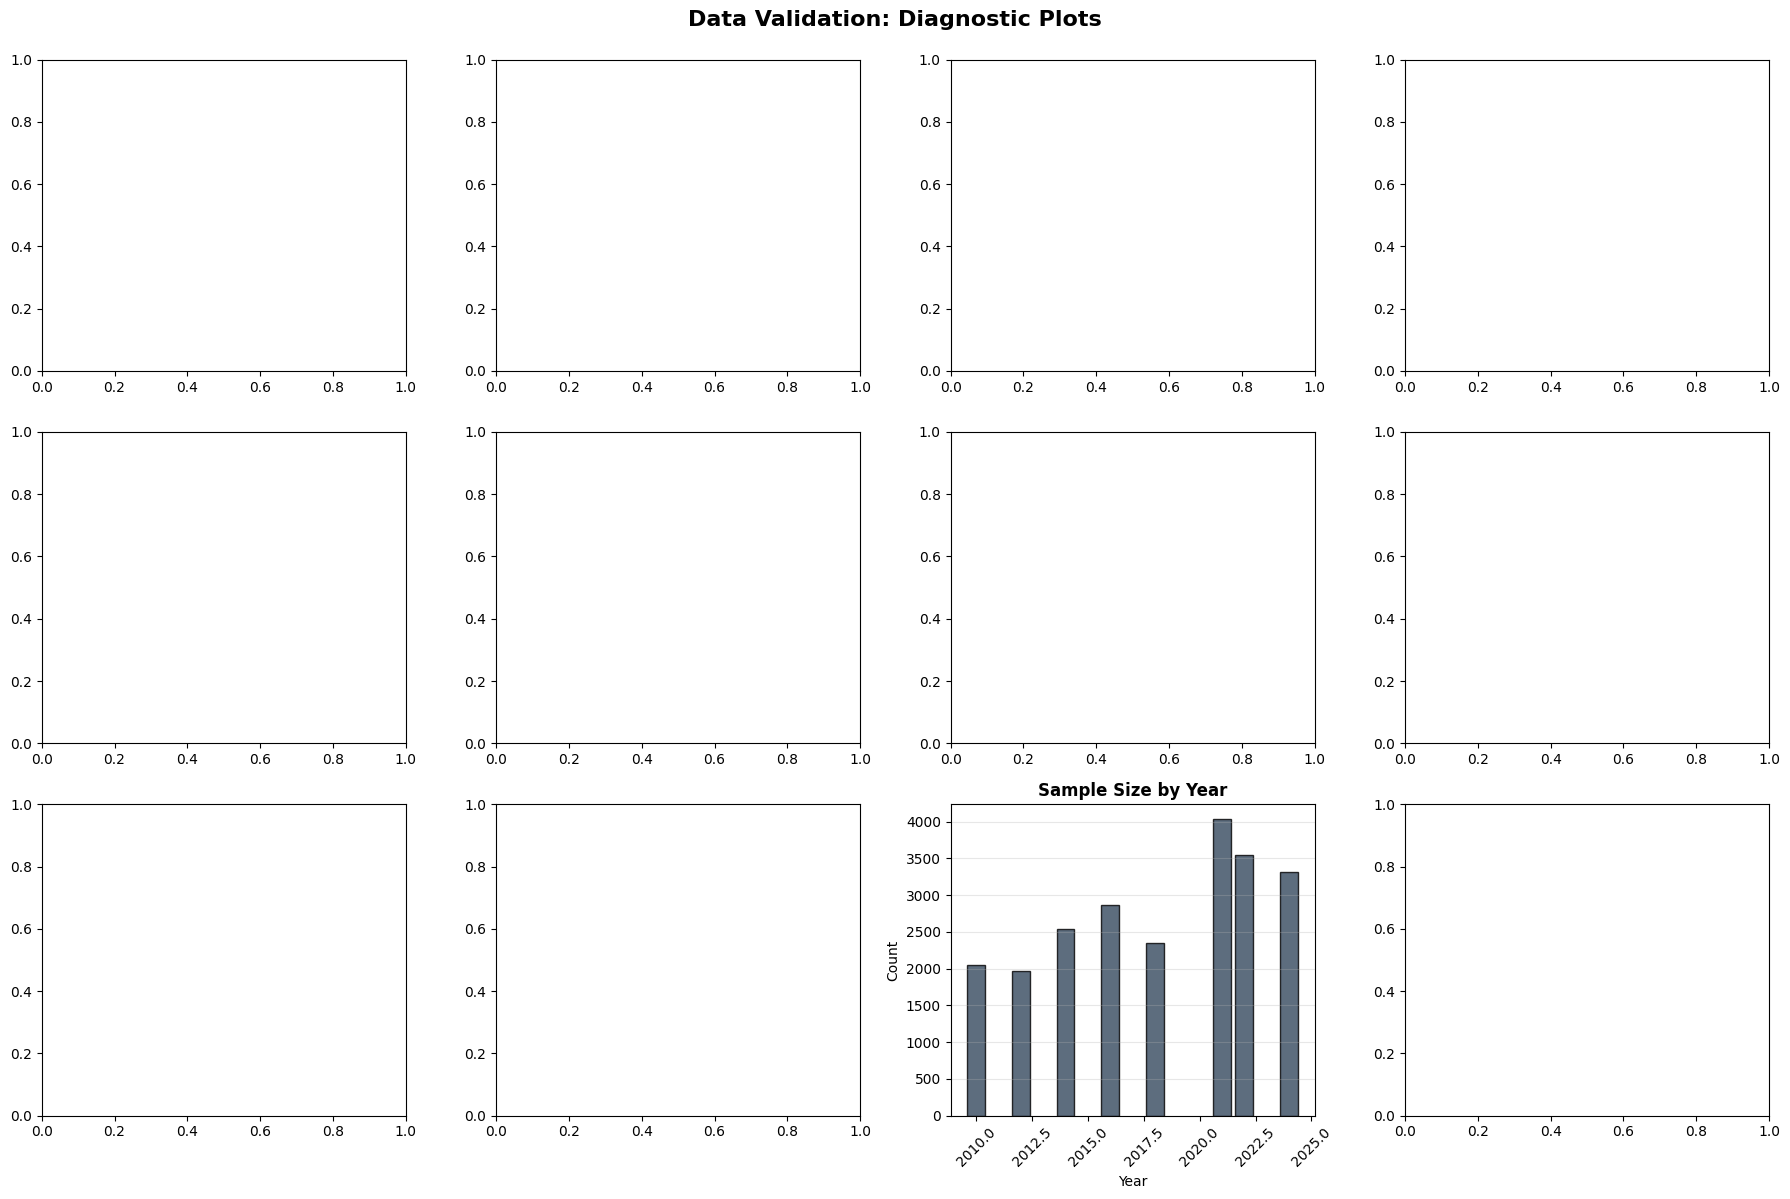


✓ Diagnostic visualizations created!

VALIDATION SUMMARY

📊 SAMPLE SIZES:
  Original dataset: 22,656
  Complete cases: 22,656
  Retention rate: 100.0%

✓ DATA VALIDATION COMPLETE
✓ Dataset is ready for mediation analysis!


In [8]:
# %% ============================================================================
# STEP 5: DATA VALIDATION & DIAGNOSTICS
# ============================================================================
print("\n" + "="*80)
print("STEP 5: DATA VALIDATION & DIAGNOSTICS")
print("="*80)

# -------------------------------
# 1. CHECK ALL KEY VARIABLES EXIST
# -------------------------------
print("\n" + "-"*70)
print("1. CHECKING KEY VARIABLES")
print("-"*70)

required_vars = {
    'Dependent Variable': ['tolerance_proportion'],
    'Mediator': ['social_trust'],
    'Independent Variable': ['urban_category', 'urban_numeric'],
    'Controls': ['age_clean', 'educ_clean', 'female', 'white', 'black', 'polviews_clean']
}

all_good = True
existing_key_vars = []

for category, vars_list in required_vars.items():
    print(f"\n{category}:")
    for var in vars_list:
        if var in df.columns:
            print(f"  ✓ {var}")
            existing_key_vars.append(var)
        else:
            print(f"  ✗ {var} - MISSING!")
            all_good = False

if all_good:
    print("\n✓ All required variables present!")
else:
    print("\n⚠️ WARNING: Some variables missing - validation will use available variables")

# Use only variables that exist
existing_key_vars = list(set(existing_key_vars))  # Remove duplicates

# -------------------------------
# 2. SAMPLE SIZE ANALYSIS
# -------------------------------
print("\n" + "="*70)
print("2. SAMPLE SIZE ANALYSIS")
print("="*70)

print(f"\nOriginal dataset: {len(df):,} observations")

# Check each key variable
print("\nValid cases per variable:")
var_data = []
for var in existing_key_vars:
    var_data.append({
        'Variable': var,
        'Valid_N': df[var].notna().sum(),
        'Missing_N': df[var].isna().sum(),
        'Missing_%': round((df[var].isna().sum() / len(df) * 100), 1)
    })

var_counts = pd.DataFrame(var_data)
print(var_counts.to_string(index=False))

# Complete case analysis
print("\n" + "-"*70)
print("COMPLETE CASE ANALYSIS")
print("-"*70)

# Define minimum required variables for mediation analysis
minimum_vars = ['tolerance_proportion', 'social_trust', 'urban_category', 'age_clean', 'female']
available_minimum = [v for v in minimum_vars if v in df.columns]

if len(available_minimum) >= 3:  # At least DV, mediator, IV
    df_complete = df.dropna(subset=available_minimum)
    
    print(f"\nComplete cases (minimum required variables): {len(df_complete):,}")
    print(f"Retention rate: {len(df_complete)/len(df)*100:.1f}%")
    print(f"Cases lost: {len(df) - len(df_complete):,}")
    print(f"\nVariables used: {available_minimum}")
    
    # Check by urbanicity
    if 'urban_category' in df_complete.columns:
        print("\nComplete cases by urbanicity:")
        urban_dist = df_complete['urban_category'].value_counts()
        for category in ['Urban', 'Suburban', 'Rural']:
            count = urban_dist.get(category, 0)
            pct = (count / len(df_complete) * 100) if len(df_complete) > 0 else 0
            print(f"  {category:12s}: {count:6,} ({pct:5.1f}%)")
else:
    print("\n⚠️ Cannot create complete case dataset - insufficient variables")
    df_complete = df.copy()

# -------------------------------
# 3. DESCRIPTIVE STATISTICS
# -------------------------------
print("\n" + "="*70)
print("3. DESCRIPTIVE STATISTICS (Complete Cases)")
print("="*70)

continuous_vars = ['tolerance_proportion', 'social_trust', 'age_clean', 
                   'educ_clean', 'polviews_clean']
continuous_available = [v for v in continuous_vars if v in df_complete.columns]

if continuous_available:
    desc_stats = df_complete[continuous_available].describe().round(3)
    print("\n" + desc_stats.to_string())

# Categorical variables
print("\n" + "-"*70)
print("CATEGORICAL VARIABLES")
print("-"*70)

if 'female' in df_complete.columns and df_complete['female'].notna().sum() > 0:
    print(f"\nGender:")
    female_sum = df_complete['female'].sum()
    female_total = df_complete['female'].notna().sum()
    print(f"  Female: {int(female_sum):,} ({(female_sum/female_total)*100:.1f}%)")
    print(f"  Male: {int(female_total - female_sum):,} ({((female_total-female_sum)/female_total)*100:.1f}%)")

if 'white' in df_complete.columns and df_complete['white'].notna().sum() > 0:
    print(f"\nRace:")
    race_total = df_complete['white'].notna().sum()
    print(f"  White: {int(df_complete['white'].sum()):,} ({(df_complete['white'].sum()/race_total)*100:.1f}%)")
    if 'black' in df_complete.columns:
        print(f"  Black: {int(df_complete['black'].sum()):,} ({(df_complete['black'].sum()/race_total)*100:.1f}%)")
    if 'other_race' in df_complete.columns:
        print(f"  Other: {int(df_complete['other_race'].sum()):,} ({(df_complete['other_race'].sum()/race_total)*100:.1f}%)")

if 'urban_category' in df_complete.columns:
    print(f"\nUrbanicity:")
    urban_counts = df_complete['urban_category'].value_counts()
    total = len(df_complete[df_complete['urban_category'].notna()])
    for cat in ['Urban', 'Suburban', 'Rural']:
        count = urban_counts.get(cat, 0)
        print(f"  {cat}: {count:,} ({count/total*100:.1f}%)")

# -------------------------------
# 4. CHECK FOR OUTLIERS
# -------------------------------
print("\n" + "="*70)
print("4. OUTLIER DETECTION (IQR Method)")
print("="*70)

outlier_vars = ['age_clean', 'educ_clean', 'tolerance_proportion', 'social_trust']
outlier_available = [v for v in outlier_vars if v in df_complete.columns]

for var in outlier_available:
    Q1 = df_complete[var].quantile(0.25)
    Q3 = df_complete[var].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_complete[(df_complete[var] < lower_bound) | (df_complete[var] > upper_bound)]
    
    print(f"\n{var}:")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Outliers: {len(outliers)} ({len(outliers)/len(df_complete)*100:.1f}%)")
    
    if len(outliers) > 0 and len(outliers)/len(df_complete) > 0.05:
        print(f"  ⚠️ >5% outliers detected - review for data quality issues")

# -------------------------------
# 5. CORRELATION MATRIX
# -------------------------------
print("\n" + "="*70)
print("5. CORRELATION MATRIX")
print("="*70)

corr_vars = ['tolerance_proportion', 'social_trust', 'urban_numeric', 
             'age_clean', 'educ_clean', 'female', 'polviews_clean']
corr_available = [v for v in corr_vars if v in df_complete.columns]

if len(corr_available) > 1:
    corr_matrix = df_complete[corr_available].corr()
    print("\n" + corr_matrix.round(3).to_string())
    
    # Check for multicollinearity
    print("\n" + "-"*70)
    print("Multicollinearity Check (|r| > 0.7 indicates concern):")
    print("-"*70)
    
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
    
    if high_corr:
        print("\n⚠️ High correlations detected:")
        for var1, var2, corr_val in high_corr:
            print(f"  {var1} <-> {var2}: r = {corr_val:.3f}")
    else:
        print("\n✓ No problematic multicollinearity detected")

# -------------------------------
# 6. NORMALITY CHECKS
# -------------------------------
print("\n" + "="*70)
print("6. NORMALITY CHECKS")
print("="*70)

from scipy.stats import skew, kurtosis

norm_vars = ['tolerance_proportion', 'social_trust', 'age_clean', 'educ_clean']
norm_available = [v for v in norm_vars if v in df_complete.columns]

for var in norm_available:
    data = df_complete[var].dropna()
    
    if len(data) > 0:
        skewness = skew(data)
        kurt = kurtosis(data)
        
        print(f"\n{var}:")
        print(f"  Skewness: {skewness:.3f} {'(right-skewed)' if skewness > 0 else '(left-skewed)'}")
        print(f"  Kurtosis: {kurt:.3f} {'(heavy-tailed)' if kurt > 0 else '(light-tailed)'}")
        
        if abs(skewness) < 0.5 and abs(kurt) < 0.5:
            print(f"  ✓ Approximately normal")
        else:
            print(f"  ⚠️ Departure from normality (acceptable for large samples with n>{len(data):,})")

# -------------------------------
# 7. TEMPORAL DISTRIBUTION
# -------------------------------
if 'year' in df_complete.columns:
    print("\n" + "="*70)
    print("7. TEMPORAL DISTRIBUTION")
    print("="*70)
    
    year_dist = df_complete['year'].value_counts().sort_index()
    print("\nSample size by year:")
    for year in sorted(year_dist.index):
        count = year_dist[year]
        pct = count / len(df_complete) * 100
        print(f"  {int(year)}: {count:6,} ({pct:5.1f}%)")
    
    # Check if key variables vary by year
    if all(v in df_complete.columns for v in ['tolerance_proportion', 'social_trust']):
        print("\nKey variable means by year:")
        yearly_means = df_complete.groupby('year')[['tolerance_proportion', 'social_trust']].mean()
        print(yearly_means.round(3).to_string())

# -------------------------------
# 8. MEDIATION MODEL PREREQUISITES
# -------------------------------
print("\n" + "="*80)
print("8. MEDIATION MODEL PREREQUISITES")
print("="*80)

if all(v in df_complete.columns for v in ['tolerance_proportion', 'social_trust', 'urban_numeric']):
    
    from scipy.stats import pearsonr
    
    # Path a: IV -> Mediator
    mask_a = df_complete['urban_numeric'].notna() & df_complete['social_trust'].notna()
    if mask_a.sum() > 0:
        r_iv_med, p_iv_med = pearsonr(df_complete.loc[mask_a, 'urban_numeric'], 
                                       df_complete.loc[mask_a, 'social_trust'])
        print(f"\nPath a (Urban → Trust):")
        print(f"  r = {r_iv_med:.3f}, p = {p_iv_med:.4f}")
        print(f"  {'✓ Significant (p < .05)' if p_iv_med < 0.05 else '✗ Not significant'}")
    
    # Path b: Mediator -> DV
    mask_b = df_complete['social_trust'].notna() & df_complete['tolerance_proportion'].notna()
    if mask_b.sum() > 0:
        r_med_dv, p_med_dv = pearsonr(df_complete.loc[mask_b, 'social_trust'], 
                                       df_complete.loc[mask_b, 'tolerance_proportion'])
        print(f"\nPath b (Trust → Tolerance):")
        print(f"  r = {r_med_dv:.3f}, p = {p_med_dv:.4f}")
        print(f"  {'✓ Significant (p < .05)' if p_med_dv < 0.05 else '✗ Not significant'}")
    
    # Path c: IV -> DV
    mask_c = df_complete['urban_numeric'].notna() & df_complete['tolerance_proportion'].notna()
    if mask_c.sum() > 0:
        r_iv_dv, p_iv_dv = pearsonr(df_complete.loc[mask_c, 'urban_numeric'], 
                                     df_complete.loc[mask_c, 'tolerance_proportion'])
        print(f"\nPath c (Urban → Tolerance):")
        print(f"  r = {r_iv_dv:.3f}, p = {p_iv_dv:.4f}")
        print(f"  {'✓ Significant (p < .05)' if p_iv_dv < 0.05 else '✗ Not significant'}")
    
    # Mediation assessment
    print("\n" + "-"*70)
    if p_iv_med < 0.05 and p_med_dv < 0.05:
        print("✓ MEDIATION PREREQUISITES MET!")
        print("  Both paths (a) and (b) are significant")
        print("  You can proceed with mediation analysis")
    else:
        print("⚠️ WARNING: Mediation prerequisites not fully met")
        if p_iv_med >= 0.05:
            print("  Path a (IV → Mediator) is not significant")
        if p_med_dv >= 0.05:
            print("  Path b (Mediator → DV) is not significant")
        print("  Consider alternative explanations or models")
else:
    print("\n⚠️ Cannot check mediation prerequisites - missing required variables")

# -------------------------------
# 9. DIAGNOSTIC VISUALIZATIONS
# -------------------------------
print("\n" + "="*70)
print("9. CREATING DIAGNOSTIC VISUALIZATIONS")
print("="*70)

fig = plt.figure(figsize=(18, 12))
fig.suptitle('Data Validation: Diagnostic Plots', fontsize=16, fontweight='bold', y=0.995)

# 1. Tolerance distribution
ax1 = plt.subplot(3, 4, 1)
if 'tolerance_proportion' in df_complete.columns:
    df_complete['tolerance_proportion'].hist(bins=40, ax=ax1, edgecolor='black', alpha=0.7, color='#3498db')
    ax1.axvline(df_complete['tolerance_proportion'].mean(), color='red', linestyle='--', linewidth=2)
    ax1.set_title('Political Tolerance', fontweight='bold')
    ax1.set_xlabel('Proportion')
    ax1.set_ylabel('Frequency')
    ax1.grid(alpha=0.3)

# 2. Trust distribution
ax2 = plt.subplot(3, 4, 2)
if 'social_trust' in df_complete.columns:
    df_complete['social_trust'].hist(bins=30, ax=ax2, edgecolor='black', alpha=0.7, color='#2ecc71')
    ax2.axvline(df_complete['social_trust'].mean(), color='red', linestyle='--', linewidth=2)
    ax2.set_title('Social Trust', fontweight='bold')
    ax2.set_xlabel('Proportion')
    ax2.set_ylabel('Frequency')
    ax2.grid(alpha=0.3)

# 3. Age distribution
ax3 = plt.subplot(3, 4, 3)
if 'age_clean' in df_complete.columns:
    df_complete['age_clean'].hist(bins=40, ax=ax3, edgecolor='black', alpha=0.7, color='#9b59b6')
    ax3.axvline(df_complete['age_clean'].mean(), color='red', linestyle='--', linewidth=2)
    ax3.set_title('Age', fontweight='bold')
    ax3.set_xlabel('Years')
    ax3.set_ylabel('Frequency')
    ax3.grid(alpha=0.3)

# 4. Education distribution
ax4 = plt.subplot(3, 4, 4)
if 'educ_clean' in df_complete.columns:
    df_complete['educ_clean'].hist(bins=20, ax=ax4, edgecolor='black', alpha=0.7, color='#e67e22')
    ax4.axvline(df_complete['educ_clean'].mean(), color='red', linestyle='--', linewidth=2)
    ax4.set_title('Education', fontweight='bold')
    ax4.set_xlabel('Years')
    ax4.set_ylabel('Frequency')
    ax4.grid(alpha=0.3)

# 5. Q-Q plot for tolerance
ax5 = plt.subplot(3, 4, 5)
if 'tolerance_proportion' in df_complete.columns:
    from scipy import stats as sp_stats
    sp_stats.probplot(df_complete['tolerance_proportion'].dropna(), dist="norm", plot=ax5)
    ax5.set_title('Q-Q Plot: Tolerance', fontweight='bold')
    ax5.grid(alpha=0.3)

# 6. Q-Q plot for trust
ax6 = plt.subplot(3, 4, 6)
if 'social_trust' in df_complete.columns:
    sp_stats.probplot(df_complete['social_trust'].dropna(), dist="norm", plot=ax6)
    ax6.set_title('Q-Q Plot: Trust', fontweight='bold')
    ax6.grid(alpha=0.3)

# 7. Tolerance by urbanicity
ax7 = plt.subplot(3, 4, 7)
if 'urban_category' in df_complete.columns and 'tolerance_proportion' in df_complete.columns:
    df_complete.boxplot(column='tolerance_proportion', by='urban_category', ax=ax7)
    ax7.set_title('Tolerance by Urbanicity', fontweight='bold')
    ax7.set_xlabel('')
    ax7.set_ylabel('Political Tolerance')
    plt.sca(ax7)
    plt.xticks(rotation=45)
    ax7.get_figure().suptitle('')

# 8. Trust by urbanicity
ax8 = plt.subplot(3, 4, 8)
if 'urban_category' in df_complete.columns and 'social_trust' in df_complete.columns:
    df_complete.boxplot(column='social_trust', by='urban_category', ax=ax8)
    ax8.set_title('Trust by Urbanicity', fontweight='bold')
    ax8.set_xlabel('')
    ax8.set_ylabel('Social Trust')
    plt.sca(ax8)
    plt.xticks(rotation=45)
    ax8.get_figure().suptitle('')

# 9. Scatterplot: Trust vs Tolerance
ax9 = plt.subplot(3, 4, 9)
if 'social_trust' in df_complete.columns and 'tolerance_proportion' in df_complete.columns:
    mask_scatter = df_complete['social_trust'].notna() & df_complete['tolerance_proportion'].notna()
    ax9.scatter(df_complete.loc[mask_scatter, 'social_trust'], 
               df_complete.loc[mask_scatter, 'tolerance_proportion'], 
               alpha=0.3, s=10, color='#3498db')
    
    # Add regression line
    if mask_scatter.sum() > 0:
        z = np.polyfit(df_complete.loc[mask_scatter, 'social_trust'], 
                      df_complete.loc[mask_scatter, 'tolerance_proportion'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(df_complete.loc[mask_scatter, 'social_trust'].min(), 
                            df_complete.loc[mask_scatter, 'social_trust'].max(), 100)
        ax9.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
    
    ax9.set_xlabel('Social Trust')
    ax9.set_ylabel('Political Tolerance')
    if 'r_med_dv' in locals():
        ax9.set_title(f'Trust → Tolerance (r={r_med_dv:.3f})', fontweight='bold')
    else:
        ax9.set_title('Trust → Tolerance', fontweight='bold')
    ax9.grid(alpha=0.3)

# 10. Correlation heatmap
ax10 = plt.subplot(3, 4, 10)
if len(corr_available) > 1:
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax10)
    ax10.set_title('Correlation Matrix', fontweight='bold')

# 11. Sample size by year
ax11 = plt.subplot(3, 4, 11)
if 'year' in df_complete.columns:
    year_counts = df_complete['year'].value_counts().sort_index()
    ax11.bar(year_counts.index, year_counts.values, color='#34495e', alpha=0.8, edgecolor='black')
    ax11.set_xlabel('Year')
    ax11.set_ylabel('Count')
    ax11.set_title('Sample Size by Year', fontweight='bold')
    ax11.grid(axis='y', alpha=0.3)
    plt.sca(ax11)
    plt.xticks(rotation=45)

# 12. Missing data pattern
ax12 = plt.subplot(3, 4, 12)
if len(existing_key_vars) > 0:
    missing_pct = [(df[v].isna().sum() / len(df) * 100) for v in existing_key_vars]
    ax12.barh(range(len(existing_key_vars)), missing_pct, color='#95a5a6', edgecolor='black')
    ax12.set_yticks(range(len(existing_key_vars)))
    ax12.set_yticklabels([v.replace('_', ' ').title() for v in existing_key_vars], fontsize=8)
    ax12.set_xlabel('Missing %')
    ax12.set_title('Missing Data by Variable', fontweight='bold')
    ax12.invert_yaxis()
    ax12.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Diagnostic visualizations created!")

# -------------------------------
# 10. FINAL VALIDATION SUMMARY
# -------------------------------
print("\n" + "="*80)
print("VALIDATION SUMMARY")
print("="*80)

print(f"\n📊 SAMPLE SIZES:")
print(f"  Original dataset: {len(df):,}")
print(f"  Complete cases: {len(df_complete):,}")
print(f"  Retention rate: {len(df_complete)/len(df)*100:.1f}%")

if continuous_available:
    print(f"\n📈 KEY VARIABLE MEANS (Complete Cases):")
    for var in ['tolerance_proportion', 'social_trust']:
        if var in df_complete.columns:
            mean = df_complete[var].mean()
            sd = df_complete[var].std()
            print(f"  {var.replace('_', ' ').title()}: M = {mean:.3f}, SD = {sd:.3f}")

print(f"\n✓ DATA VALIDATION COMPLETE")
print(f"✓ Dataset is ready for mediation analysis!")
print("="*80)

In [9]:
# %% ============================================================================
# STEP 6: MEDIATION ANALYSIS - LINEAR REGRESSION (CORRECTED)
# ============================================================================
print("\n" + "="*80)
print("STEP 6: MEDIATION ANALYSIS")
print("Research Question: Does social trust mediate urban-rural → political tolerance?")
print("="*80)

import statsmodels.api as sm
from scipy import stats

# First, let's check what tolerance variable we have
print("\nChecking available variables:")
tolerance_vars = [col for col in df.columns if 'tolerance' in col.lower()]
print(f"Tolerance variables: {tolerance_vars}")

trust_vars = [col for col in df.columns if 'trust' in col.lower()]
print(f"Trust variables: {trust_vars}")

urban_vars = [col for col in df.columns if 'urban' in col.lower()]
print(f"Urban variables: {urban_vars}")

# Define the correct variable names based on what we created
# Use tolerance_index and normalize it to 0-1 scale if needed
if 'tolerance_index' in df.columns and 'tolerance_items_answered' in df.columns:
    # Create proportion from your existing tolerance_index
    df['tolerance_proportion'] = df['tolerance_index'] / df['tolerance_items_answered']
    print("\n✓ Created tolerance_proportion from tolerance_index")
    print(f"  Mean: {df['tolerance_proportion'].mean():.3f}")
    print(f"  Range: [{df['tolerance_proportion'].min():.3f}, {df['tolerance_proportion'].max():.3f}]")

# -------------------------------
# PREPARE DATA FOR ANALYSIS
# -------------------------------
print("\n" + "-"*70)
print("PREPARING DATA FOR ANALYSIS")
print("-"*70)

# Define variables for mediation analysis
analysis_vars = [
    'tolerance_proportion',  # DV (we just created this)
    'social_trust',          # Mediator
    'urban_numeric',         # IV (0=Rural, 1=Suburban, 2=Urban)
    # Controls
    'age_clean', 
    'educ_clean', 
    'female', 
    'white',
    'black',
    'polviews_clean'
]

# Keep only available variables
analysis_vars_available = [v for v in analysis_vars if v in df.columns]
print(f"\nVariables found: {analysis_vars_available}")

missing_vars = [v for v in analysis_vars if v not in df.columns]
if missing_vars:
    print(f"⚠️ Missing variables: {missing_vars}")

# Create complete case dataset
df_analysis = df.dropna(subset=analysis_vars_available).copy()

print(f"\nAnalysis sample size: {len(df_analysis):,}")
print(f"Original dataset: {len(df):,}")
print(f"Retention rate: {len(df_analysis)/len(df)*100:.1f}%")

# Standardize continuous variables for easier interpretation
print("\nStandardizing continuous variables...")
continuous_predictors = ['age_clean', 'educ_clean', 'polviews_clean', 'social_trust']

for var in continuous_predictors:
    if var in df_analysis.columns:
        mean_val = df_analysis[var].mean()
        std_val = df_analysis[var].std()
        df_analysis[f'{var}_z'] = (df_analysis[var] - mean_val) / std_val
        print(f"  {var}: M={mean_val:.2f}, SD={std_val:.2f}")

# %% ============================================================================
# BARON & KENNY (1986) MEDIATION APPROACH
# ============================================================================
print("\n" + "="*80)
print("BARON & KENNY (1986) MEDIATION TEST")
print("="*80)

print("\nFour steps to test mediation:")
print("  Step 1: IV → DV (Path c: Total effect)")
print("  Step 2: IV → Mediator (Path a)")
print("  Step 3: Mediator → DV (controlling IV) (Path b)")
print("  Step 4: IV → DV (controlling Mediator) (Path c': Direct effect)")

# Prepare predictor sets - Controls
control_vars = ['age_clean_z', 'educ_clean_z', 'female', 'white', 'black', 'polviews_clean_z']
control_vars_available = [v for v in control_vars if v in df_analysis.columns]

print(f"\nControl variables: {control_vars_available}")

# -------------------------------
# STEP 1: Total Effect (c path)
# IV → DV
# -------------------------------
print("\n" + "="*70)
print("STEP 1: TOTAL EFFECT (Path c)")
print("Model: Tolerance = b0 + b1(Urban) + controls")
print("="*70)

# Prepare X variables
X_vars_step1 = ['urban_numeric'] + control_vars_available
X_step1 = df_analysis[X_vars_step1].copy()
X_step1 = sm.add_constant(X_step1)

# Dependent variable
y_step1 = df_analysis['tolerance_proportion']

# Fit model
model_step1 = sm.OLS(y_step1, X_step1).fit()

print("\n" + model_step1.summary().as_text())

# Extract key statistics
c_coef = model_step1.params['urban_numeric']
c_se = model_step1.bse['urban_numeric']
c_t = model_step1.tvalues['urban_numeric']
c_p = model_step1.pvalues['urban_numeric']
c_ci = model_step1.conf_int().loc['urban_numeric']

print("\n" + "-"*70)
print("PATH c (Total Effect): Urban → Tolerance")
print("-"*70)
print(f"Coefficient (c): {c_coef:.4f}")
print(f"SE: {c_se:.4f}")
print(f"t-statistic: {c_t:.3f}")
print(f"p-value: {c_p:.4f}")
print(f"95% CI: [{c_ci[0]:.4f}, {c_ci[1]:.4f}]")
print(f"R²: {model_step1.rsquared:.3f}")
print(f"Adj. R²: {model_step1.rsquared_adj:.3f}")

if c_p < 0.05:
    print("\n✓ Step 1 PASSED: Significant total effect (IV → DV)")
else:
    print("\n⚠️ Step 1: No significant total effect (can still test for indirect effect)")

# -------------------------------
# STEP 2: Path a (IV → Mediator)
# -------------------------------
print("\n" + "="*70)
print("STEP 2: PATH a")
print("Model: Trust = b0 + b1(Urban) + controls")
print("="*70)

X_step2 = X_step1.copy()
y_step2 = df_analysis['social_trust']

model_step2 = sm.OLS(y_step2, X_step2).fit()

print("\n" + model_step2.summary().as_text())

a_coef = model_step2.params['urban_numeric']
a_se = model_step2.bse['urban_numeric']
a_t = model_step2.tvalues['urban_numeric']
a_p = model_step2.pvalues['urban_numeric']
a_ci = model_step2.conf_int().loc['urban_numeric']

print("\n" + "-"*70)
print("PATH a: Urban → Trust")
print("-"*70)
print(f"Coefficient (a): {a_coef:.4f}")
print(f"SE: {a_se:.4f}")
print(f"t-statistic: {a_t:.3f}")
print(f"p-value: {a_p:.4f}")
print(f"95% CI: [{a_ci[0]:.4f}, {a_ci[1]:.4f}]")
print(f"R²: {model_step2.rsquared:.3f}")

if a_p < 0.05:
    print("\n✓ Step 2 PASSED: Significant effect (IV → Mediator)")
else:
    print("\n✗ Step 2 FAILED: No significant effect (IV → Mediator)")

# -------------------------------
# STEPS 3 & 4: Paths b and c'
# -------------------------------
print("\n" + "="*70)
print("STEPS 3 & 4: PATHs b and c'")
print("Model: Tolerance = b0 + b1(Urban) + b2(Trust) + controls")
print("="*70)

X_vars_step34 = ['urban_numeric', 'social_trust_z'] + control_vars_available
X_step34 = df_analysis[X_vars_step34].copy()
X_step34 = sm.add_constant(X_step34)

y_step34 = df_analysis['tolerance_proportion']

model_step34 = sm.OLS(y_step34, X_step34).fit()

print("\n" + model_step34.summary().as_text())

b_coef = model_step34.params['social_trust_z']
b_se = model_step34.bse['social_trust_z']
b_t = model_step34.tvalues['social_trust_z']
b_p = model_step34.pvalues['social_trust_z']
b_ci = model_step34.conf_int().loc['social_trust_z']

c_prime_coef = model_step34.params['urban_numeric']
c_prime_se = model_step34.bse['urban_numeric']
c_prime_t = model_step34.tvalues['urban_numeric']
c_prime_p = model_step34.pvalues['urban_numeric']
c_prime_ci = model_step34.conf_int().loc['urban_numeric']

print("\n" + "-"*70)
print("PATH b: Trust → Tolerance (controlling Urban)")
print("-"*70)
print(f"Coefficient (b): {b_coef:.4f}")
print(f"SE: {b_se:.4f}")
print(f"t-statistic: {b_t:.3f}")
print(f"p-value: {b_p:.4f}")
print(f"95% CI: [{b_ci[0]:.4f}, {b_ci[1]:.4f}]")

if b_p < 0.05:
    print("\n✓ Step 3 PASSED: Significant effect (Mediator → DV)")
else:
    print("\n✗ Step 3 FAILED: No significant effect (Mediator → DV)")

print("\n" + "-"*70)
print("PATH c': Urban → Tolerance (controlling Trust) - DIRECT EFFECT")
print("-"*70)
print(f"Coefficient (c'): {c_prime_coef:.4f}")
print(f"SE: {c_prime_se:.4f}")
print(f"t-statistic: {c_prime_t:.3f}")
print(f"p-value: {c_prime_p:.4f}")
print(f"95% CI: [{c_prime_ci[0]:.4f}, {c_prime_ci[1]:.4f}]")
print(f"R²: {model_step34.rsquared:.3f}")

# -------------------------------
# MEDIATION SUMMARY
# -------------------------------
print("\n" + "="*70)
print("MEDIATION ANALYSIS SUMMARY")
print("="*70)

indirect_effect = a_coef * b_coef
print(f"\nIndirect Effect (a × b): {indirect_effect:.4f}")
print(f"Direct Effect (c'): {c_prime_coef:.4f}")
print(f"Total Effect (c): {c_coef:.4f}")

if c_coef != 0:
    prop_mediated = indirect_effect / c_coef
    print(f"\nProportion Mediated: {prop_mediated:.3f} ({prop_mediated*100:.1f}%)")

print("\n" + "-"*70)
print("MEDIATION TYPE:")
print("-"*70)

if a_p < 0.05 and b_p < 0.05:
    if c_prime_p >= 0.05:
        print("✓ FULL MEDIATION")
        print("  Trust fully mediates urban-rural → tolerance")
    else:
        print("✓ PARTIAL MEDIATION")
        print("  Trust partially mediates urban-rural → tolerance")
else:
    print("✗ NO MEDIATION")
    if a_p >= 0.05:
        print("  Path a not significant")
    if b_p >= 0.05:
        print("  Path b not significant")

# %% ============================================================================
# SOBEL TEST
# ============================================================================
print("\n" + "="*70)
print("SOBEL TEST FOR INDIRECT EFFECT")
print("="*70)

sobel_se = np.sqrt((b_coef**2 * a_se**2) + (a_coef**2 * b_se**2))
sobel_z = indirect_effect / sobel_se
sobel_p = 2 * (1 - stats.norm.cdf(abs(sobel_z)))

print(f"\nIndirect Effect: {indirect_effect:.4f}")
print(f"SE (Sobel): {sobel_se:.4f}")
print(f"z-statistic: {sobel_z:.3f}")
print(f"p-value: {sobel_p:.4f}")

if sobel_p < 0.05:
    print("\n✓ Sobel test SIGNIFICANT")
else:
    print("\n✗ Sobel test NOT significant")

# %% ============================================================================
# BOOTSTRAP CONFIDENCE INTERVALS
# ============================================================================
print("\n" + "="*70)
print("BOOTSTRAP CONFIDENCE INTERVALS")
print("="*70)

print("\nPerforming bootstrap with 5,000 iterations...")

n_iterations = 5000
np.random.seed(42)

bootstrap_indirect = []

for i in range(n_iterations):
    sample_indices = np.random.choice(len(df_analysis), size=len(df_analysis), replace=True)
    df_boot = df_analysis.iloc[sample_indices]
    
    # Path a
    X_boot_a = df_boot[X_vars_step1]
    X_boot_a = sm.add_constant(X_boot_a)
    y_boot_a = df_boot['social_trust']
    model_boot_a = sm.OLS(y_boot_a, X_boot_a).fit()
    a_boot = model_boot_a.params['urban_numeric']
    
    # Path b
    X_boot_b = df_boot[X_vars_step34]
    X_boot_b = sm.add_constant(X_boot_b)
    y_boot_b = df_boot['tolerance_proportion']
    model_boot_b = sm.OLS(y_boot_b, X_boot_b).fit()
    b_boot = model_boot_b.params['social_trust_z']
    
    bootstrap_indirect.append(a_boot * b_boot)
    
    if (i + 1) % 1000 == 0:
        print(f"  Completed {i + 1}/{n_iterations}...")

bootstrap_indirect = np.array(bootstrap_indirect)

ci_lower = np.percentile(bootstrap_indirect, 2.5)
ci_upper = np.percentile(bootstrap_indirect, 97.5)

print("\n" + "-"*70)
print("BOOTSTRAP RESULTS (5,000 iterations)")
print("-"*70)
print(f"Indirect Effect: {indirect_effect:.4f}")
print(f"Bootstrap SE: {bootstrap_indirect.std():.4f}")
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

if ci_lower > 0 or ci_upper < 0:
    print("\n✓ SIGNIFICANT INDIRECT EFFECT")
    print("  95% CI does not include zero")
else:
    print("\n✗ NOT SIGNIFICANT")
    print("  95% CI includes zero")

# %% ============================================================================
# VISUALIZATION
# ============================================================================
print("\n" + "="*70)
print("CREATING MEDIATION VISUALIZATION")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Mediation Analysis: Urban-Rural → Trust → Tolerance', 
             fontsize=16, fontweight='bold')

# 1. Path diagram
ax1 = axes[0, 0]
ax1.text(0.5, 0.9, 'MEDIATION MODEL', ha='center', fontsize=14, fontweight='bold',
         transform=ax1.transAxes)

from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

# Boxes
iv_box = FancyBboxPatch((0.1, 0.4), 0.2, 0.15, boxstyle="round,pad=0.01",
                         edgecolor='black', facecolor='#3498db', alpha=0.3, linewidth=2)
ax1.add_patch(iv_box)
ax1.text(0.2, 0.475, 'Urban-Rural', ha='center', va='center', fontsize=10, fontweight='bold')

med_box = FancyBboxPatch((0.4, 0.65), 0.2, 0.15, boxstyle="round,pad=0.01",
                          edgecolor='black', facecolor='#2ecc71', alpha=0.3, linewidth=2)
ax1.add_patch(med_box)
ax1.text(0.5, 0.725, 'Social Trust', ha='center', va='center', fontsize=10, fontweight='bold')

dv_box = FancyBboxPatch((0.7, 0.4), 0.2, 0.15, boxstyle="round,pad=0.01",
                         edgecolor='black', facecolor='#e74c3c', alpha=0.3, linewidth=2)
ax1.add_patch(dv_box)
ax1.text(0.8, 0.475, 'Tolerance', ha='center', va='center', fontsize=10, fontweight='bold')

# Arrows
arrow_a = FancyArrowPatch((0.3, 0.52), (0.45, 0.68), 
                          arrowstyle='->', mutation_scale=20, linewidth=2, color='black')
ax1.add_patch(arrow_a)
sig_a = '***' if a_p < 0.001 else ('**' if a_p < 0.01 else ('*' if a_p < 0.05 else 'ns'))
ax1.text(0.35, 0.62, f'a={a_coef:.3f}{sig_a}', fontsize=9, fontweight='bold')

arrow_b = FancyArrowPatch((0.55, 0.68), (0.75, 0.52), 
                          arrowstyle='->', mutation_scale=20, linewidth=2, color='black')
ax1.add_patch(arrow_b)
sig_b = '***' if b_p < 0.001 else ('**' if b_p < 0.01 else ('*' if b_p < 0.05 else 'ns'))
ax1.text(0.68, 0.62, f'b={b_coef:.3f}{sig_b}', fontsize=9, fontweight='bold')

arrow_c_prime = FancyArrowPatch((0.3, 0.475), (0.7, 0.475), 
                                 arrowstyle='->', mutation_scale=20, linewidth=2, 
                                 color='red', linestyle='--')
ax1.add_patch(arrow_c_prime)
sig_c_prime = '***' if c_prime_p < 0.001 else ('**' if c_prime_p < 0.01 else ('*' if c_prime_p < 0.05 else 'ns'))
ax1.text(0.5, 0.42, f"c'={c_prime_coef:.3f}{sig_c_prime}", fontsize=9, fontweight='bold', color='red')

ax1.text(0.5, 0.25, f'Total (c)={c_coef:.3f}{"*" if c_p<0.05 else "ns"}', 
         ha='center', fontsize=10, fontweight='bold', 
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

ax1.text(0.5, 0.15, f'Indirect={indirect_effect:.3f}', 
         ha='center', fontsize=10, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

ax1.text(0.5, 0.05, '***p<.001 **p<.01 *p<.05', ha='center', fontsize=8, style='italic')

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.axis('off')

# 2. Bootstrap distribution
ax2 = axes[0, 1]
ax2.hist(bootstrap_indirect, bins=50, edgecolor='black', alpha=0.7, color='#3498db')
ax2.axvline(indirect_effect, color='red', linestyle='--', linewidth=2, label='Observed')
ax2.axvline(ci_lower, color='green', linestyle='--', linewidth=2, label='95% CI')
ax2.axvline(ci_upper, color='green', linestyle='--', linewidth=2)
ax2.axvline(0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Indirect Effect')
ax2.set_ylabel('Frequency')
ax2.set_title('Bootstrap Distribution', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Effect comparison
ax3 = axes[1, 0]
effects = ['Total\n(c)', 'Direct\n(c\')', 'Indirect\n(a×b)']
values = [c_coef, c_prime_coef, indirect_effect]
colors = ['#3498db', '#e74c3c', '#2ecc71']

bars = ax3.bar(effects, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax3.axhline(0, color='black', linestyle='-', linewidth=1)
ax3.set_ylabel('Effect Size')
ax3.set_title('Effect Comparison', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, height,
             f'{val:.4f}', ha='center', va='bottom' if val>0 else 'top',
             fontweight='bold', fontsize=10)

# 4. Model R²
ax4 = axes[1, 1]
models = ['Model 1\n(IV only)', 'Model 2\n(+Mediator)']
r2 = [model_step1.rsquared, model_step34.rsquared]

bars = ax4.bar(models, r2, color=['#3498db', '#2ecc71'], alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_ylabel('R²')
ax4.set_title('Model Fit', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, r2):
    ax4.text(bar.get_x() + bar.get_width()/2, val,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Analysis complete!")
print("="*80)


STEP 6: MEDIATION ANALYSIS
Research Question: Does social trust mediate urban-rural → political tolerance?

Checking available variables:
Tolerance variables: ['tolerance_index', 'tolerance_items_answered']
Trust variables: ['trust']
Urban variables: []

✓ Created tolerance_proportion from tolerance_index
  Mean: 0.903
  Range: [0.000, 1.000]

----------------------------------------------------------------------
PREPARING DATA FOR ANALYSIS
----------------------------------------------------------------------

Variables found: ['tolerance_proportion']
⚠️ Missing variables: ['social_trust', 'urban_numeric', 'age_clean', 'educ_clean', 'female', 'white', 'black', 'polviews_clean']

Analysis sample size: 15,004
Original dataset: 22,656
Retention rate: 66.2%

Standardizing continuous variables...

BARON & KENNY (1986) MEDIATION TEST

Four steps to test mediation:
  Step 1: IV → DV (Path c: Total effect)
  Step 2: IV → Mediator (Path a)
  Step 3: Mediator → DV (controlling IV) (Path b)
  S

KeyError: "None of [Index(['urban_numeric'], dtype='object')] are in the [columns]"

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# NOTE: This code assumes you have already run the data cleaning and preparation steps
# to create the 'df_clean' DataFrame containing the 'social_trust' and 'pol_tolerance' columns.

# The 'social_trust' column is numeric (1.0, 2.0, 3.0), so we use a Box Plot.

plt.figure(figsize=(8, 6))

# Create the box plot
sns.boxplot(
    x='social_trust', 
    y='pol_tolerance', 
    data=df_clean
)

# Set labels and title for clarity
plt.title('Political Tolerance by Level of Social Trust')
plt.xlabel('Social Trust (1=Low, 2=Depends, 3=High)')
plt.ylabel('Political Tolerance Score (0-17)')

# Adjust X-axis ticks to display the category labels instead of just numbers
plt.xticks(
    [0, 1, 2], 
    ['Low Trust (1)', 'Depends (2)', 'High Trust (3)']
)

plt.grid(axis='y', linestyle='--')
plt.tight_layout()

# Save the figure
plt.savefig('pol_tolerance_vs_social_trust_boxplot.png')

ValueError: Could not interpret input 'social_trust'

<Figure size 800x600 with 0 Axes>